In [1]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
#for clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
## for explainer
from lime import lime_tabular

from sklearn.model_selection import train_test_split # for data partition.
from sklearn.metrics import r2_score # to identify r_squared for regression model.
from sklearn.linear_model import LinearRegression # for linear regression model.
from pandas.plotting import scatter_matrix, parallel_coordinates

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from dmba import plotDecisionTree, classificationSummary, regressionSummary

# Loading 'Clean' Data 

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('Data_RedFin_clean_data.csv')
df.tail()

Unnamed: 0                 street      city state zipcode    price  bed  \
1170        1170      382 Fontanelle Dr  San jose    Ca   95111  1049000    4   
1171        1171      1882 Johnston Ave  San jose    Ca   95125  3395000    4   
1172        1172  809 Auzerais Ave #401  San jose    Ca   95126   900000    2   
1173        1173     47 N Claremont Ave  San jose    Ca   95127   948000    3   
1174        1174   3300 NARVAEZ Ave #45  San jose    Ca   95136   349000    3   

      bath    sqft  walkscore  transitscore  bikescore  competitivescore  \
1170   2.0  1542.0          9            27         43                78   
1171   4.0  2931.0         53            38         58                65   
1172   2.0  1274.0         83            60         88                71   
1173   2.0  1320.0         42             0         44                63   
1174   2.0  1584.0         50            46         56                 0   

      1st School Rating  status               house_type  year_built  Lotsize  \
1170                4.0  Active       Single Family Home        1980   6911.0   
1171                7.0  Active       Single Family Home        1950   6520.0   
1172                3.0  Active                    Condo        2008      0.0   
1173                5.0  Active       Single Family Home        1946   6220.0   
1174                5.0  Active  Double-Wide Mobile Home        1995      0.0   

      perSq_Ft  Price_Level  
1170     680.0            1  
1171    1158.0            1  
1172     706.0            0  
1173     718.0            0  
1174     220.0            0

In [3]:
df = df.drop(df.columns[0], axis = 1)

In [4]:
#removing price as an outlier

#price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

#sqft
Q1 = df['sqft'].quantile(0.25)
Q3 = df['sqft'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['sqft'] >= (Q1 - 1.5 * IQR)) & (df['sqft'] <= (Q3 + 1.5 * IQR))]

In [5]:
df['House_Type'] = [ 'SingleFamily/Triplex/LargeMultiFamily' if index == "Triplex" or index == "Single Family Home" or index == "Multi-Family (5+ Unit)"
                             else 'Mobile Home' if index == "Mobile/Manufactured Home" or index == "Double-Wide Mobile Home" or index == "Triple-Wide Mobile Home"
                            else 'Condo/Townhouse/Duplex'
                             for index in df['house_type']]

In [6]:
df['county']= ['San Francisco County' if index == 'San francisco'
              else 'Alameda County' if index in ['Oakland', 'Fremont' ,'Pleasanton' ,'Alameda', 'Berkeley' ,'Hayward' ,'Newark',
 'San leandro', 'Dublin' ,'Castro valley' ,'Emeryville' ,'Union city',
 'San lorenzo', 'Livermore', 'Albany', 'Sunol']
              else 'Santa Clara County' for index in df['city']]

In [7]:
#df['Price_Level'] = ['$0-$100']
#price buckets for kNN and other models
df['price_bucket'], cut_bin = pd.qcut(
    df['price'], q = 5, 
    labels = [1,2,3,4,5], retbins = True)
df['price_bucket']=df['price_bucket'].cat.codes
#df.info()
#df.price_bucket.value_counts()
print (cut_bin) #'<=$60000', '<=$798977.6', '<=$1096800', '<=$1395000', '<=$3500000'

[  60000.   798977.6 1096800.  1395000.  1895000.  3500000. ]


In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
df.tail()

street      city state zipcode    price  bed  bath  \
1040      382 Fontanelle Dr  San jose    Ca   95111  1049000    4   2.0   
1041      1882 Johnston Ave  San jose    Ca   95125  3395000    4   4.0   
1042  809 Auzerais Ave #401  San jose    Ca   95126   900000    2   2.0   
1043     47 N Claremont Ave  San jose    Ca   95127   948000    3   2.0   
1044   3300 NARVAEZ Ave #45  San jose    Ca   95136   349000    3   2.0   

        sqft  walkscore  transitscore  bikescore  competitivescore  \
1040  1542.0          9            27         43                78   
1041  2931.0         53            38         58                65   
1042  1274.0         83            60         88                71   
1043  1320.0         42             0         44                63   
1044  1584.0         50            46         56                 0   

      1st School Rating  status               house_type  year_built  Lotsize  \
1040                4.0  Active       Single Family Home        1980   6911.0   
1041                7.0  Active       Single Family Home        1950   6520.0   
1042                3.0  Active                    Condo        2008      0.0   
1043                5.0  Active       Single Family Home        1946   6220.0   
1044                5.0  Active  Double-Wide Mobile Home        1995      0.0   

      perSq_Ft  Price_Level                             House_Type  \
1040     680.0            1  SingleFamily/Triplex/LargeMultiFamily   
1041    1158.0            1  SingleFamily/Triplex/LargeMultiFamily   
1042     706.0            0                 Condo/Townhouse/Duplex   
1043     718.0            0  SingleFamily/Triplex/LargeMultiFamily   
1044     220.0            0                            Mobile Home   

                  county  price_bucket  
1040  Santa Clara County             1  
1041  Santa Clara County             4  
1042  Santa Clara County             1  
1043  Santa Clara County             1  
1044  Santa Clara County             0

In [10]:
#df.to_csv('CleanRedfinData.csv')

# Data Analysis

In [11]:
df.columns

Index(['street', 'city', 'state', 'zipcode', 'price', 'bed', 'bath', 'sqft',
       'walkscore', 'transitscore', 'bikescore', 'competitivescore',
       '1st School Rating', 'status', 'house_type', 'year_built', 'Lotsize',
       'perSq_Ft', 'Price_Level', 'House_Type', 'county', 'price_bucket'],
      dtype='object')

In [12]:
#getting right data types

for col in ['street', 'city', 'state', 'zipcode', 'status', 'house_type']:
    df[col] = df[col].astype('object')

for col in ['price', 'bed', 'bath', 'sqft', 'walkscore', 'transitscore', 'bikescore', 'competitivescore',
       '1st School Rating', 'year_built', 'Lotsize',
       'perSq_Ft', 'Price_Level']:
    df[col] = df[col].astype('int')

In [13]:
types = df.dtypes
print(types)

df.isna().sum()

street               object
city                 object
state                object
zipcode              object
price                 int32
bed                   int32
bath                  int32
sqft                  int32
walkscore             int32
transitscore          int32
bikescore             int32
competitivescore      int32
1st School Rating     int32
status               object
house_type           object
year_built            int32
Lotsize               int32
perSq_Ft              int32
Price_Level           int32
House_Type           object
county               object
price_bucket           int8
dtype: object


street               0
city                 0
state                0
zipcode              0
price                0
bed                  0
bath                 0
sqft                 0
walkscore            0
transitscore         0
bikescore            0
competitivescore     0
1st School Rating    0
status               0
house_type           0
year_built           0
Lotsize              0
perSq_Ft             0
Price_Level          0
House_Type           0
county               0
price_bucket         0
dtype: int64

(0.0, 3500000.0)

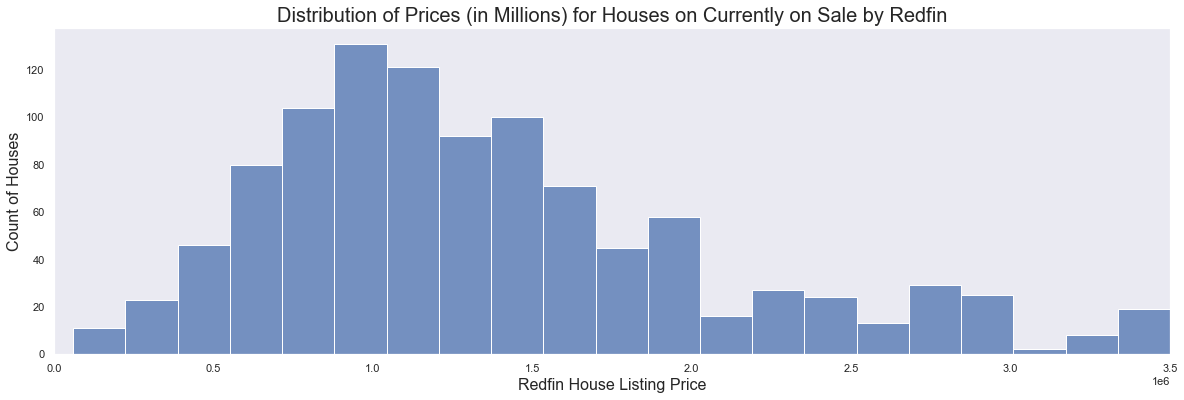

In [14]:
#Getting distribution of predictor variable -- price

#Let's get a sense of the distribution in prices in the bay using SNS

plt.figure(figsize=(20, 6))
sns.set(style = 'dark')
sns.histplot(df['price'])
plt.title('Distribution of Prices (in Millions) for Houses on Currently on Sale by Redfin', fontsize = 20)
plt.xlabel('Redfin House Listing Price', fontsize = 16)
plt.ylabel('Count of Houses', fontsize = 16)
plt.xlim(0, 3500000)

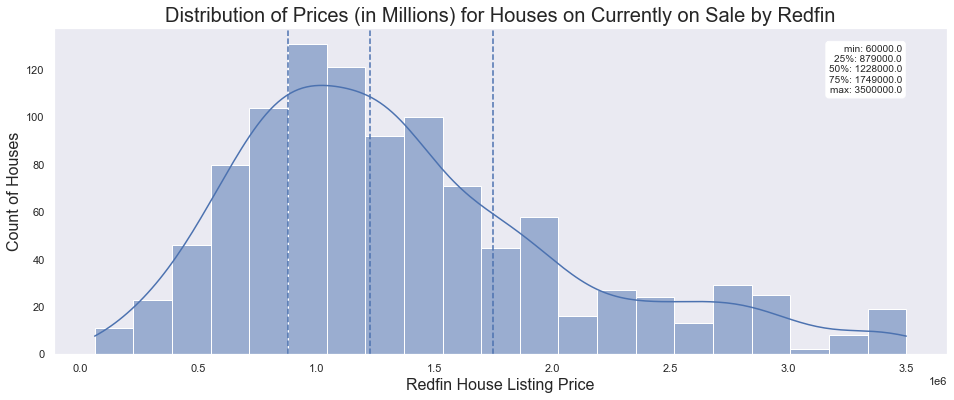

In [15]:
x = "price"
fig, ax = plt.subplots(figsize=(16, 6))
ax.title.set_text('Distribution of Sale Price')
variable = df[x].fillna(df[x].mean())
sns.histplot(variable, kde=True)
des = df[x].describe()
ax.axvline(des["25%"], ls='--')
ax.axvline(des["50%"], ls='--')
ax.axvline(des["75%"], ls='--')
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "50%: "+des["50%"], "75%: "+des["75%"], "max: "+des["max"]))
ax.text(0.95, 0.95, box, transform=ax.transAxes, fontsize=10, va='top', 
        ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

plt.title('Distribution of Prices (in Millions) for Houses on Currently on Sale by Redfin', fontsize = 20)
plt.xlabel('Redfin House Listing Price', fontsize = 16)
plt.ylabel('Count of Houses', fontsize = 16)
plt.show()

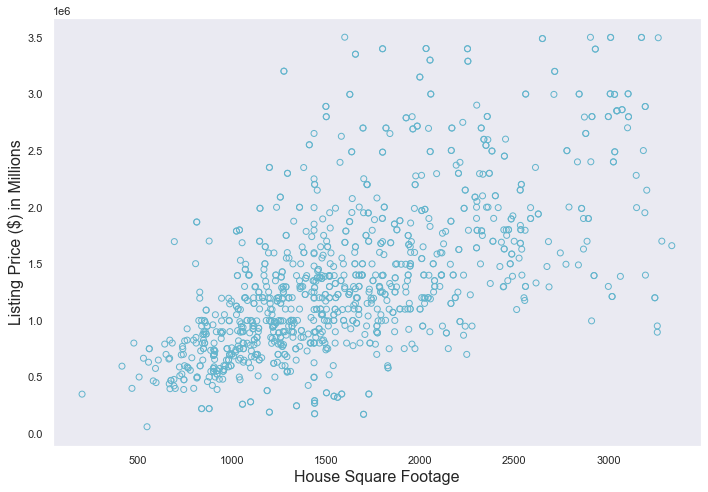

In [16]:
#Check that data makes sense-- scatter plot between square footage and msrp -- should be a positive trend


fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

ax.scatter(df['sqft'], df['price'], color='C9', facecolor='none') #facecolor none leaves the bubble unfilled

#plt.xlim(0, 5000)
#plt.ylim(0, 2000000)
plt.xlabel('House Square Footage', fontsize = 16)
plt.ylabel('Listing Price ($) in Millions', fontsize = 16)

plt.tight_layout()
plt.show()

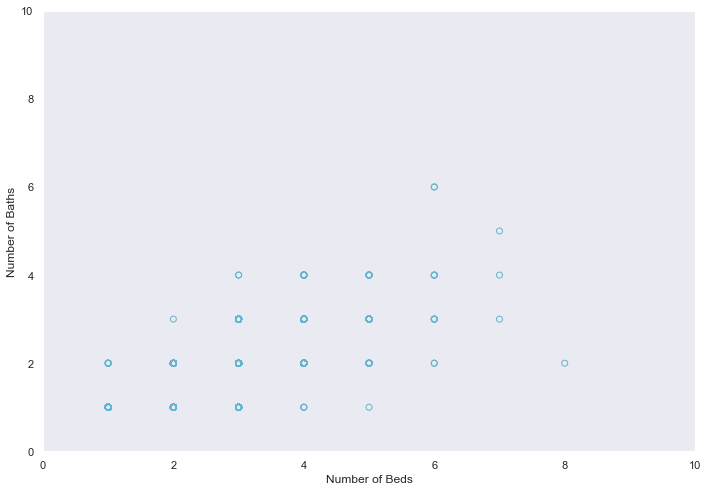

In [17]:
#Similarly, the more beds a place has- likely to have more baths as well

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

ax.scatter(df['bed'], df['bath'], color='C9', facecolor='none') #facecolor none leaves the bubble unfilled

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('Number of Beds')
plt.ylabel('Number of Baths')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count of Houses')

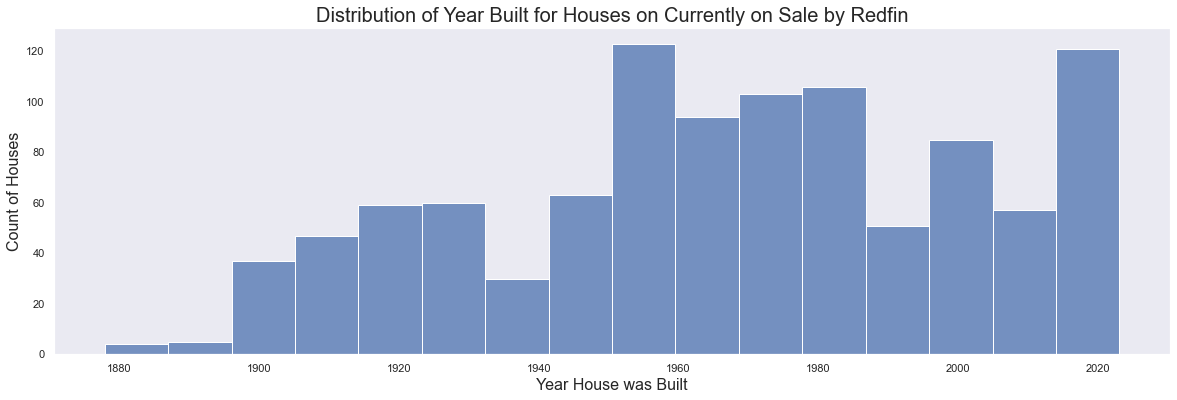

In [18]:
#General distributions of the data - state of real estate market in bay area currently

#Distribution of the year_built of houses currently on sale by Redfin in the bay

plt.figure(figsize=(20, 6))
sns.set(style = 'dark')
sns.histplot(df['year_built'])
plt.title('Distribution of Year Built for Houses on Currently on Sale by Redfin', fontsize = 20)
plt.xlabel('Year House was Built', fontsize = 16)
plt.ylabel('Count of Houses', fontsize = 16)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

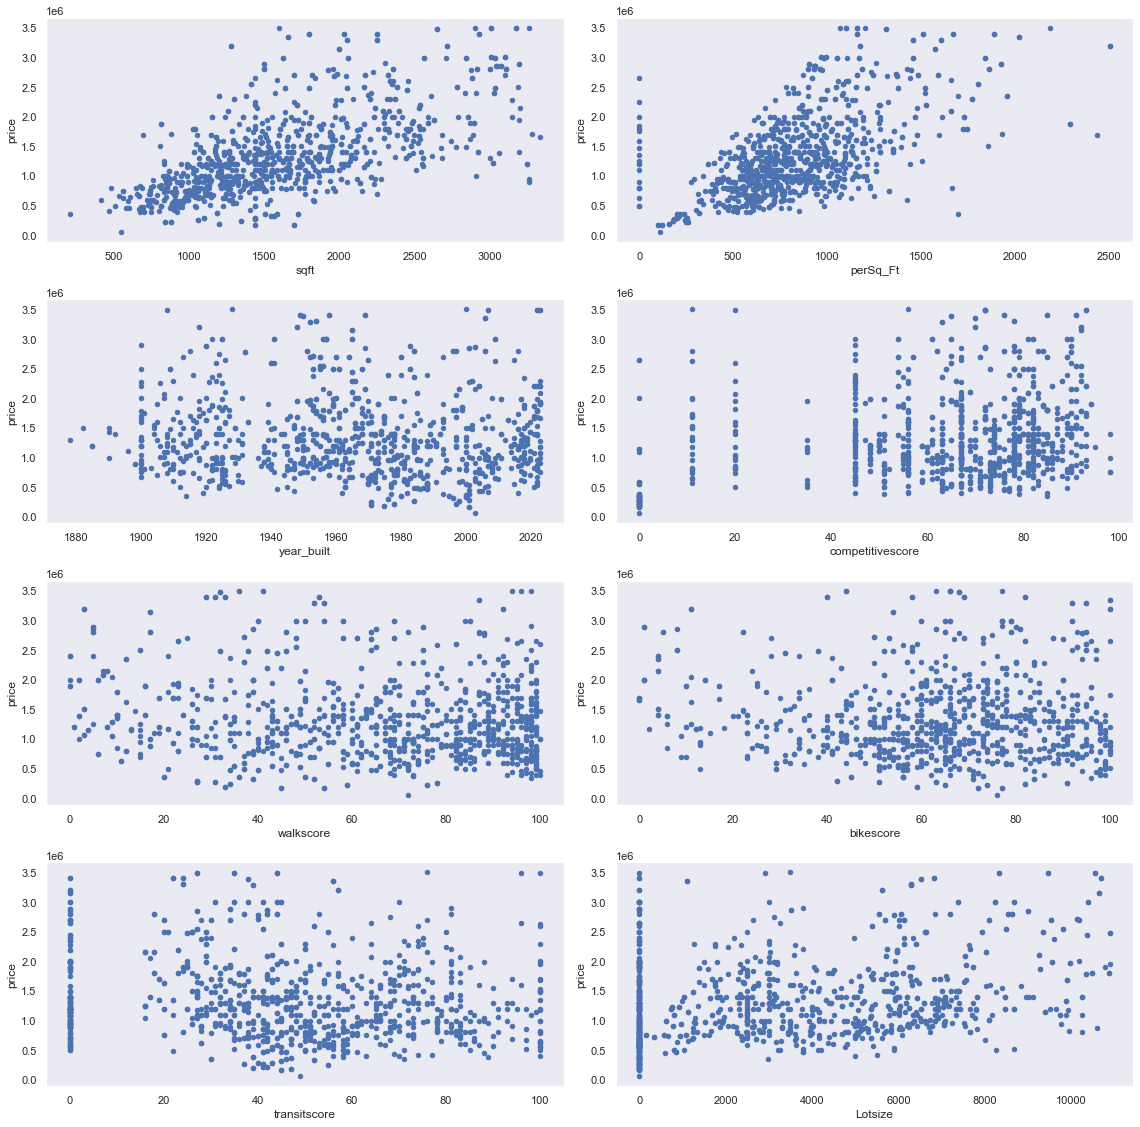

In [19]:
#Generate scater plots to get a sense of how different variables correlate with a house's listing price

fig, axes = plt.subplots(nrows=4, ncols=2, figsize = [16,16])
df.plot.scatter(x = 'sqft', y = 'price', ax=axes[0,0])
df.plot.scatter(x = 'perSq_Ft', y = 'price', ax=axes[0,1])
df.plot.scatter(x = 'year_built', y = 'price', ax=axes[1,0])
df.plot.scatter(x = 'competitivescore', y = 'price', ax=axes[1,1])
df.plot.scatter(x = 'walkscore', y = 'price', ax=axes[2,0])
df.plot.scatter(x = 'bikescore', y = 'price', ax=axes[2,1])
df.plot.scatter(x = 'transitscore', y = 'price', ax=axes[3,0])
df.plot.scatter(x = 'Lotsize', y = 'price', ax=axes[3,1])
plt.suptitle('')  # Suppress the overall title
plt.tight_layout()  # Increase the separation between the plots

plt.show()

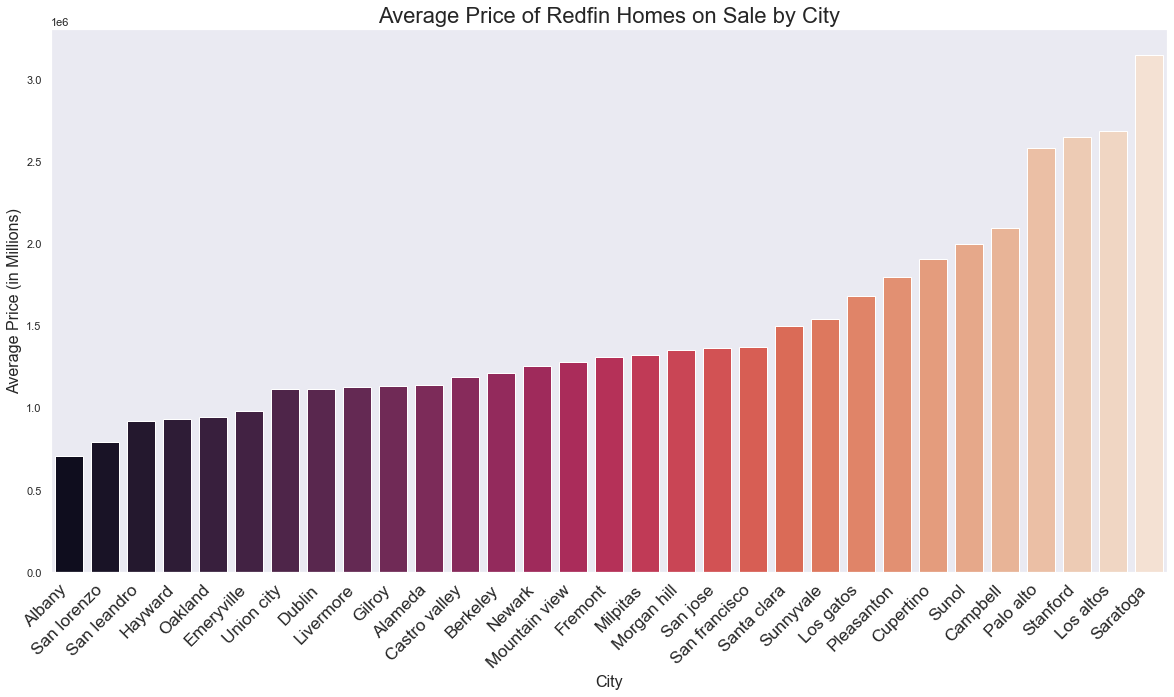

In [20]:
#Let's get a sense of the variation between cities on different factors - starting with price

data = df.groupby(['city']).mean()['price'].sort_values(ascending = True)

#data = data.sort_values(ascending = False)

sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="rocket")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average Price of Redfin Homes on Sale by City', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('Average Price (in Millions)', fontsize = 16)
plt.show()

In [21]:
df.columns

Index(['street', 'city', 'state', 'zipcode', 'price', 'bed', 'bath', 'sqft',
       'walkscore', 'transitscore', 'bikescore', 'competitivescore',
       '1st School Rating', 'status', 'house_type', 'year_built', 'Lotsize',
       'perSq_Ft', 'Price_Level', 'House_Type', 'county', 'price_bucket'],
      dtype='object')

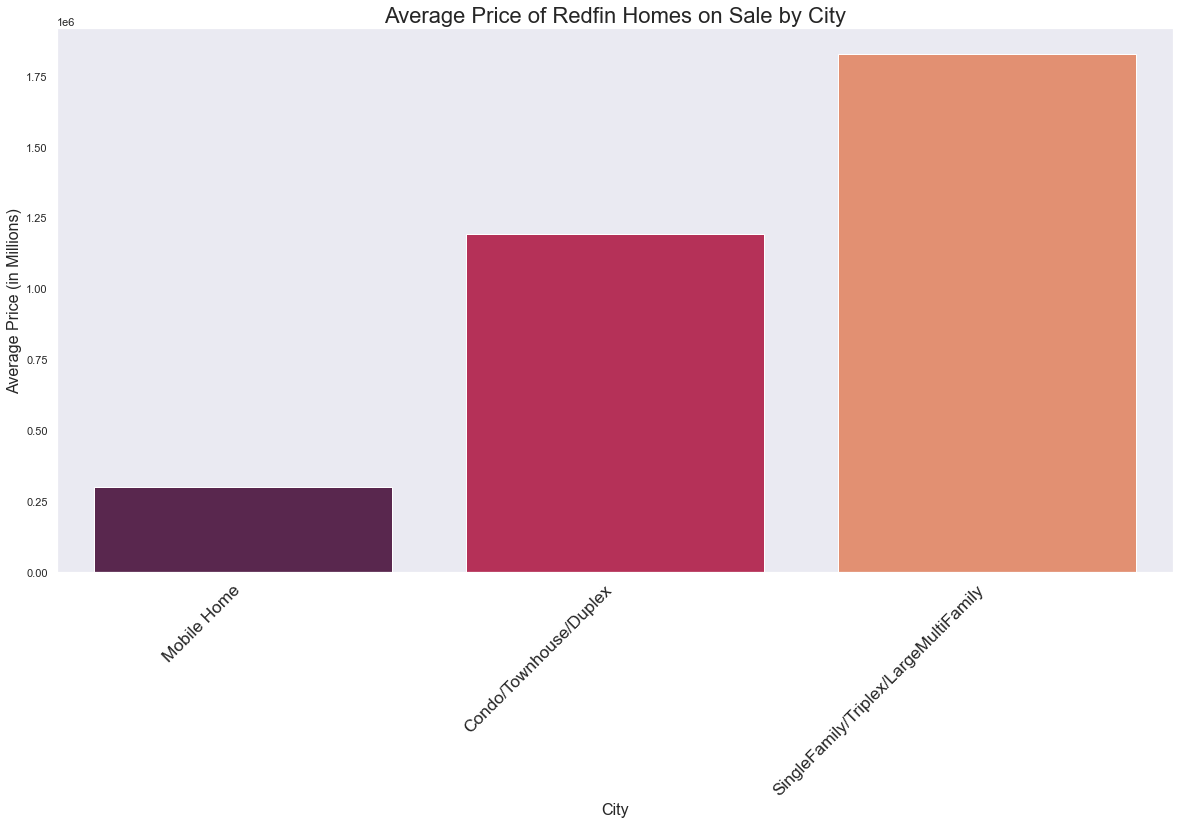

In [22]:
#Let's get a sense of the variation between cities on different factors - starting with price

data = df.groupby(['House_Type']).mean()['price'].sort_values(ascending = True)

#data = data.sort_values(ascending = False)

sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="rocket")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average Price of Redfin Homes on Sale by City', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('Average Price (in Millions)', fontsize = 16)
plt.show()

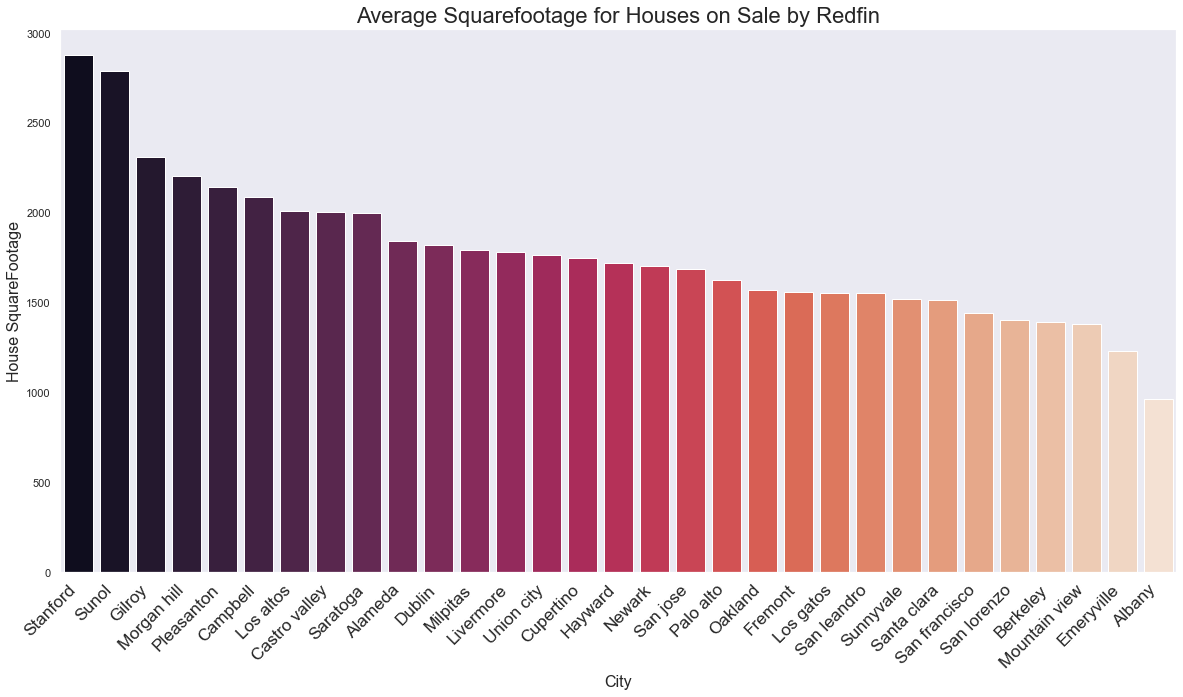

In [23]:
#Looking at average sqft of homes in different cities

data = df.groupby(['city']).mean()['sqft'].sort_values(ascending=False)
sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="rocket")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average Squarefootage for Houses on Sale by Redfin', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('House SquareFootage', fontsize = 16)
plt.show()

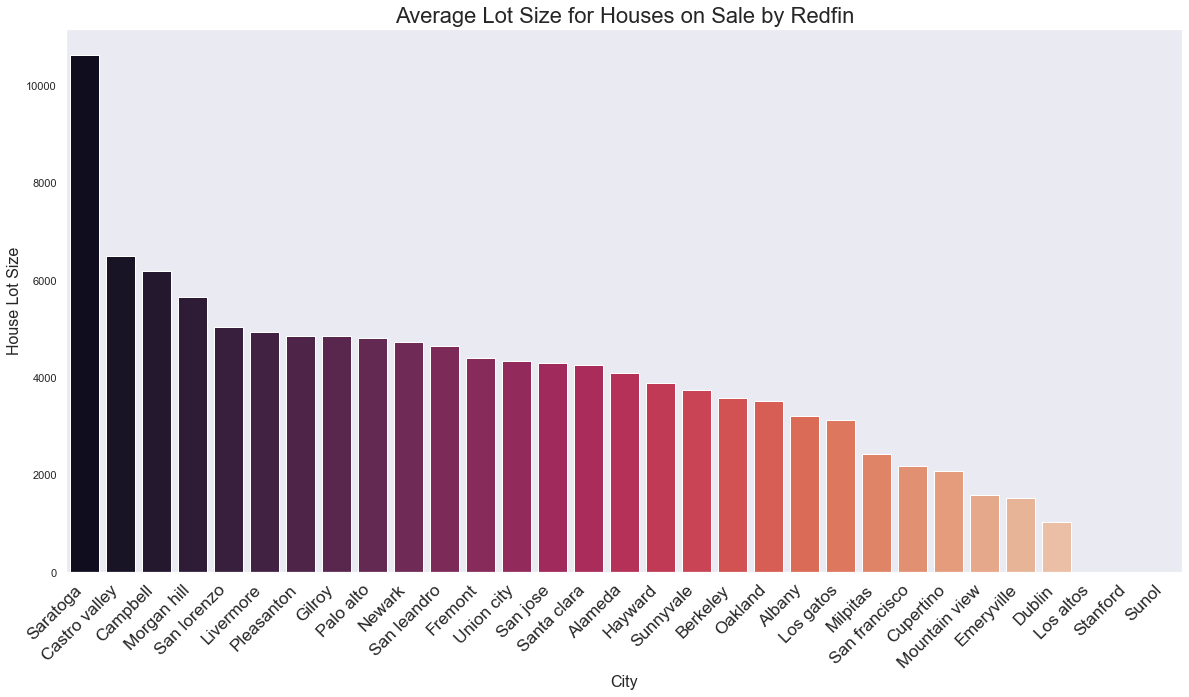

In [24]:
#Average Lot Size of homes in different cities

data = df.groupby(['city']).mean()['Lotsize'].sort_values(ascending=False)
sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="rocket")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average Lot Size for Houses on Sale by Redfin', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('House Lot Size', fontsize = 16)
plt.show()

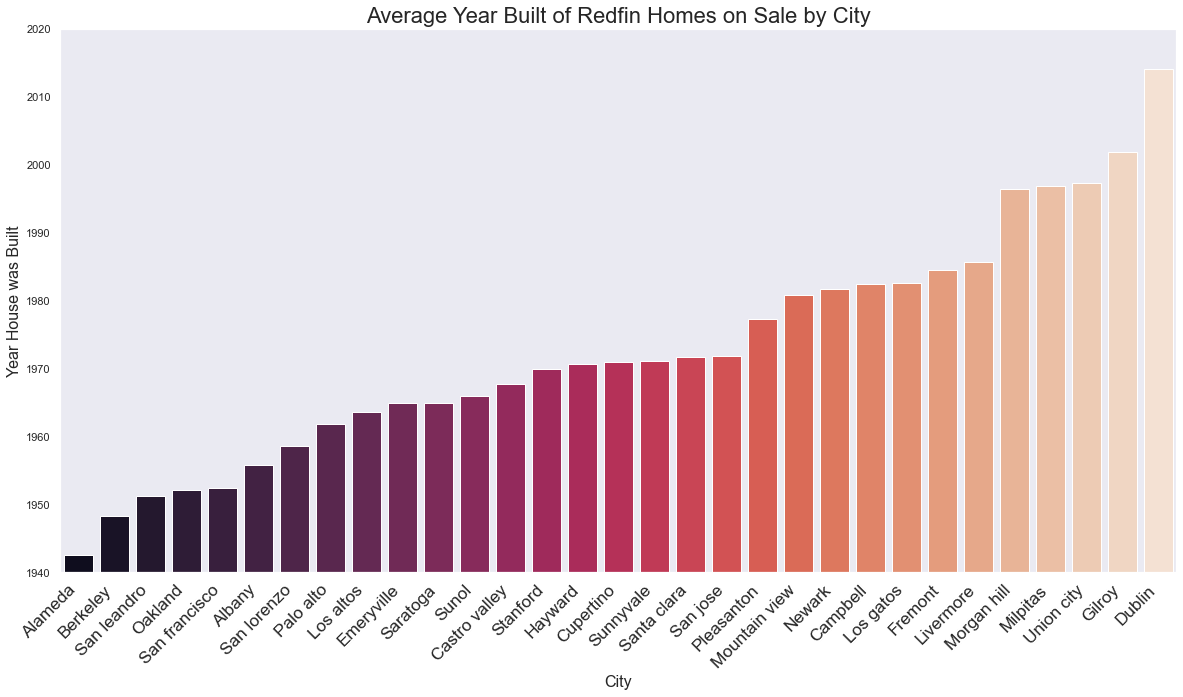

In [25]:
#Looking at the age of houses on sale in different cities in the bay

data = df.groupby(['city']).mean()['year_built'].sort_values(ascending=True)
sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="rocket")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average Year Built of Redfin Homes on Sale by City', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('Year House was Built', fontsize = 16)
plt.ylim(1940, 2020)
plt.show()

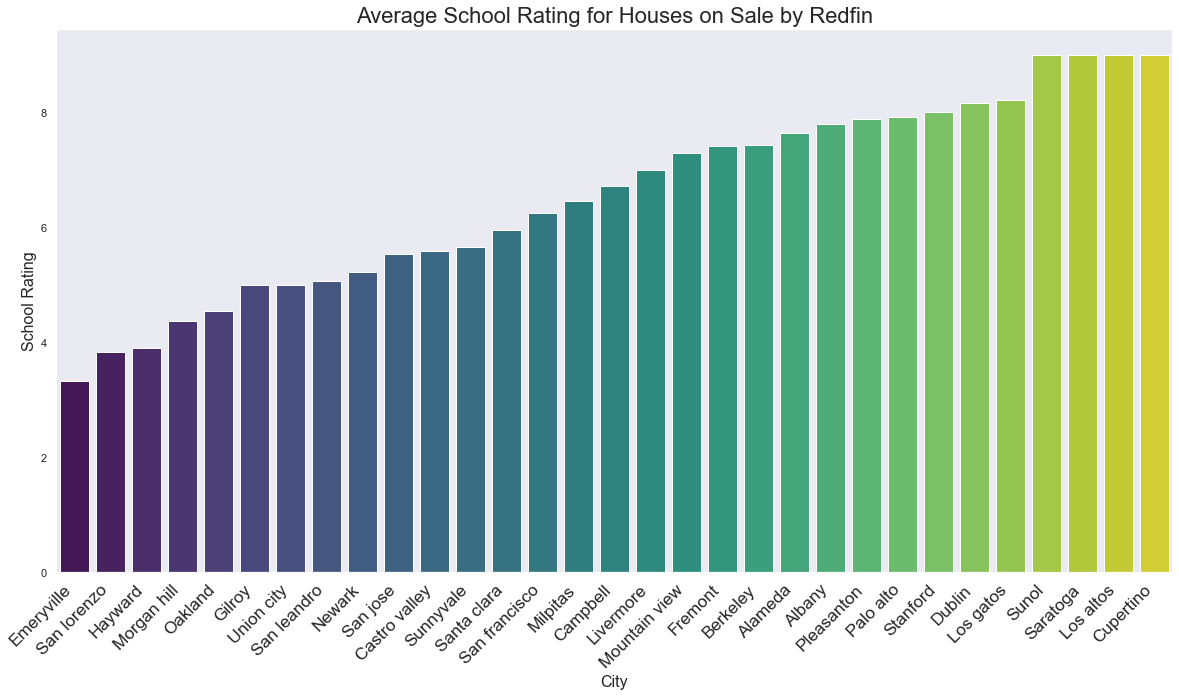

In [26]:
#School Ratings of homes in different cities

data = df.groupby(['city']).mean()['1st School Rating'].sort_values(ascending=True)
sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="viridis")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average School Rating for Houses on Sale by Redfin', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('School Rating', fontsize = 16)
plt.show()

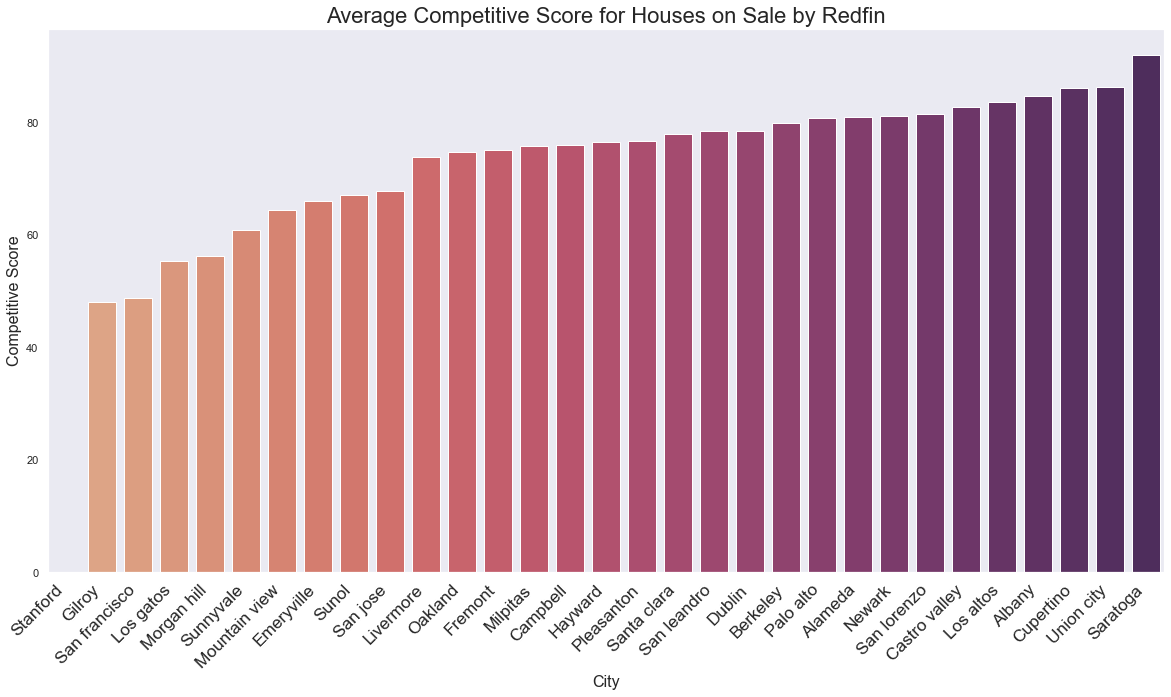

In [27]:
#Average Competitive Score of homes in different cities

data = df.groupby(['city']).mean()['competitivescore'].sort_values(ascending=True)
sns.set_style("dark")
plt.figure(figsize=(20,10))
sns.barplot(x=data.index, y=data.values,palette="flare")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.title('Average Competitive Score for Houses on Sale by Redfin', fontsize = 22)
plt.xlabel('City', fontsize = 16)
plt.ylabel('Competitive Score', fontsize = 16)
plt.show()

<AxesSubplot:xlabel='price', ylabel='Count'>

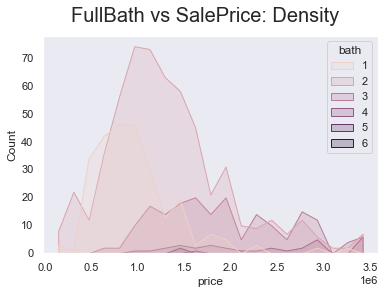

In [28]:
#Looking at distirbution of bathrooms to see its predictive power

fig, ax = plt.subplots()
fig.suptitle("FullBath vs SalePrice: Density", fontsize=20)
sns.histplot(data = df, x = "price", hue = "bath", element="poly")

<AxesSubplot:xlabel='price', ylabel='Count'>

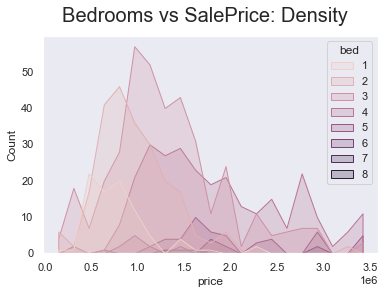

In [29]:
#Looking at distirbution of bedrooms to see its predictive power

fig, ax = plt.subplots()
fig.suptitle("Bedrooms vs SalePrice: Density", fontsize=20)
sns.histplot(data = df, x = "price", hue = "bed", element="poly")

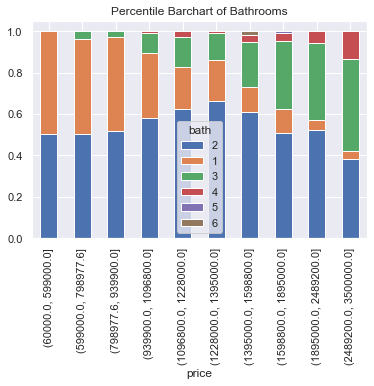

In [30]:
cat, num = "bath", "price"
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
#tmp

tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"] 
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, legend=True, grid=True)
plt.title('Percentile Barchart of Bathrooms')
plt.show()

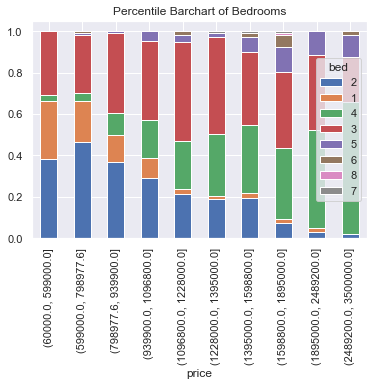

In [31]:
cat, num = "bed", "price"
breaks = np.quantile(df[num], q=np.linspace(0,1,11))
tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df[cat].unique()]
#tmp

tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"] 
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, legend=True, grid=True)
plt.title('Percentile Barchart of Bedrooms')
plt.show()

Text(0.5, 1.0, 'pearson correlation')

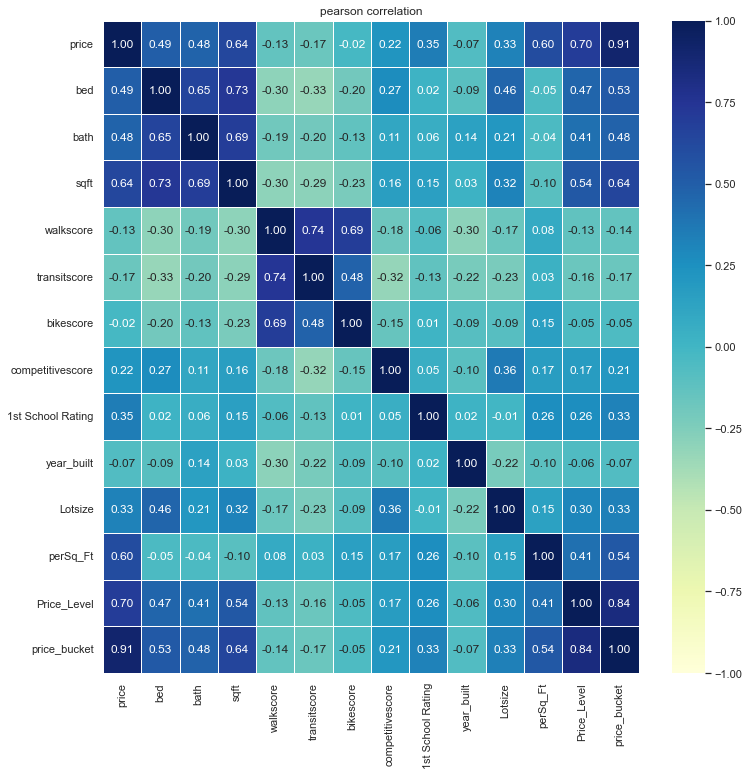

In [32]:
#AVZ
fig, ax = plt.subplots(figsize=(12,12))      
corr_matrix = df.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=1, ax = ax)
plt.title("pearson correlation")

# Data Processing

In [33]:
df.columns

Index(['street', 'city', 'state', 'zipcode', 'price', 'bed', 'bath', 'sqft',
       'walkscore', 'transitscore', 'bikescore', 'competitivescore',
       '1st School Rating', 'status', 'house_type', 'year_built', 'Lotsize',
       'perSq_Ft', 'Price_Level', 'House_Type', 'county', 'price_bucket'],
      dtype='object')

In [34]:
#Not using some of the other variables because can see right off the back that it doesnt have direct correlation with price, but can be useful for clustering
houses_df = df[['price', 'bed', 'bath', 'sqft', 'House_Type', 'year_built', 'city'] ]

In [35]:
train_houses, valid_houses = train_test_split(houses_df, test_size=0.4, random_state=1)

In [36]:
#adding dummies on training

## create dummy
dummy = pd.get_dummies(train_houses["House_Type"], 
                       prefix="House_Type",drop_first=True)
train_houses = pd.concat([train_houses, dummy], axis=1)
print( train_houses.filter(like="House_Type",axis=1).head() )
## drop the original categorical column
train_houses = train_houses.drop("House_Type", axis=1)

                                 House_Type  House_Type_Mobile Home  \
146                  Condo/Townhouse/Duplex                       0   
118                  Condo/Townhouse/Duplex                       0   
1025  SingleFamily/Triplex/LargeMultiFamily                       0   
982   SingleFamily/Triplex/LargeMultiFamily                       0   
836   SingleFamily/Triplex/LargeMultiFamily                       0   

      House_Type_SingleFamily/Triplex/LargeMultiFamily  
146                                                  0  
118                                                  0  
1025                                                 1  
982                                                  1  
836                                                  1  


In [37]:
#Create dummy for cities as well

dummy = pd.get_dummies(train_houses["city"], 
                       prefix="city",drop_first=True)
train_houses = pd.concat([train_houses, dummy], axis=1)
print( train_houses.filter(like="city",axis=1).head() )
## drop the original categorical column
train_houses = train_houses.drop("city", axis=1)

             city  city_Albany  city_Berkeley  city_Campbell  \
146       Oakland            0              0              0   
118     Livermore            0              0              0   
1025     Campbell            0              0              1   
982   Morgan hill            0              0              0   
836      San jose            0              0              0   

      city_Castro valley  city_Cupertino  city_Dublin  city_Emeryville  \
146                    0               0            0                0   
118                    0               0            0                0   
1025                   0               0            0                0   
982                    0               0            0                0   
836                    0               0            0                0   

      city_Fremont  city_Gilroy  city_Hayward  city_Livermore  city_Los altos  \
146              0            0             0               0               0   
118     

In [38]:
## scale trianing X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(train_houses.drop("price", axis=1))
train_houses_scaled= pd.DataFrame(X, columns=train_houses.drop("price", 
                        axis=1).columns, index=train_houses.index)
## scale training Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
train_houses_scaled["price"] = scalerY.fit_transform(train_houses["price"].values.reshape(-1,1))
train_houses_scaled.head()

bed  bath      sqft  year_built  House_Type_Mobile Home  \
146   1.0   0.0  0.892365   -1.085714                     0.0   
118   0.5   0.0  0.180225    0.419048                     0.0   
1025  1.0   2.0  1.912390    0.647619                     0.0   
982   0.5   0.0  0.538173    0.190476                     0.0   
836   0.5   0.0  0.700876    0.152381                     0.0   

      House_Type_SingleFamily/Triplex/LargeMultiFamily  city_Albany  \
146                                                0.0          0.0   
118                                                0.0          0.0   
1025                                               1.0          0.0   
982                                                1.0          0.0   
836                                                1.0          0.0   

      city_Berkeley  city_Campbell  city_Castro valley  city_Cupertino  \
146             0.0            0.0                 0.0             0.0   
118             0.0            0.0                 0.0             0.0   
1025            0.0            1.0                 0.0             0.0   
982             0.0            0.0                 0.0             0.0   
836             0.0            0.0                 0.0             0.0   

      city_Dublin  city_Emeryville  city_Fremont  city_Gilroy  city_Hayward  \
146           0.0              0.0           0.0          0.0           0.0   
118           0.0              0.0           0.0          0.0           0.0   
1025          0.0              0.0           0.0          0.0           0.0   
982           0.0              0.0           0.0          0.0           0.0   
836           0.0              0.0           0.0          0.0           0.0   

      city_Livermore  city_Los altos  city_Los gatos  city_Milpitas  \
146              0.0             0.0             0.0            0.0   
118              1.0             0.0             0.0            0.0   
1025             0.0             0.0             0.0            0.0   
982              0.0             0.0             0.0            0.0   
836              0.0             0.0             0.0            0.0   

      city_Morgan hill  city_Mountain view  city_Newark  city_Oakland  \
146                0.0                 0.0          0.0           1.0   
118                0.0                 0.0          0.0           0.0   
1025               0.0                 0.0          0.0           0.0   
982                1.0                 0.0          0.0           0.0   
836                0.0                 0.0          0.0           0.0   

      city_Palo alto  city_Pleasanton  city_San francisco  city_San jose  \
146              0.0              0.0                 0.0            0.0   
118              0.0              0.0                 0.0            0.0   
1025             0.0              0.0                 0.0            0.0   
982              0.0              0.0                 0.0            0.0   
836              0.0              0.0                 0.0            1.0   

      city_San leandro  city_San lorenzo  city_Santa clara  city_Saratoga  \
146                0.0               0.0               0.0            0.0   
118                0.0               0.0               0.0            0.0   
1025               0.0               0.0               0.0            0.0   
982                0.0               0.0               0.0            0.0   
836                0.0               0.0               0.0            0.0   

      city_Stanford  city_Sunnyvale  city_Sunol  city_Union city     price  
146             0.0             0.0         0.0              0.0 -0.481127  
118             0.0             0.0         0.0              0.0 -0.107155  
1025            0.0             0.0         0.0              0.0  1.752113  
982             0.0             0.0         0.0              0.0 -0.219718  
836             0.0             0.0         0.0              0.0  0.004507

In [39]:
#doing the same for testing/validation data

In [40]:
## create dummy
dummy = pd.get_dummies(valid_houses["House_Type"], 
                       prefix="House_Type",drop_first=True)
valid_houses = pd.concat([valid_houses, dummy], axis=1)
print( valid_houses.filter(like="House_Type",axis=1).head() )
## drop the original categorical column
valid_houses = valid_houses.drop("House_Type", axis=1)

                                House_Type  House_Type_Mobile Home  \
949  SingleFamily/Triplex/LargeMultiFamily                       0   
94                  Condo/Townhouse/Duplex                       0   
135                 Condo/Townhouse/Duplex                       0   
614  SingleFamily/Triplex/LargeMultiFamily                       0   
354                 Condo/Townhouse/Duplex                       0   

     House_Type_SingleFamily/Triplex/LargeMultiFamily  
949                                                 1  
94                                                  0  
135                                                 0  
614                                                 1  
354                                                 0  


In [41]:
#Create dummy for cities as well

dummy = pd.get_dummies(valid_houses["city"], 
                       prefix="city",drop_first=True)
valid_houses = pd.concat([valid_houses, dummy], axis=1)
print( valid_houses.filter(like="city",axis=1).head() )
## drop the original categorical column
valid_houses = valid_houses.drop("city", axis=1)

              city  city_Albany  city_Berkeley  city_Campbell  \
949       San jose            0              0              0   
94         Fremont            0              0              0   
135  Castro valley            0              0              0   
614       San jose            0              0              0   
354  San francisco            0              0              0   

     city_Castro valley  city_Cupertino  city_Dublin  city_Emeryville  \
949                   0               0            0                0   
94                    0               0            0                0   
135                   1               0            0                0   
614                   0               0            0                0   
354                   0               0            0                0   

     city_Fremont  city_Gilroy  city_Hayward  city_Livermore  city_Los altos  \
949             0            0             0               0               0   
94        

In [42]:
## scale valid X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(valid_houses.drop("price", axis=1))
valid_houses_scaled= pd.DataFrame(X, columns=valid_houses.drop("price", 
                        axis=1).columns, index=valid_houses.index)
## scale valid Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
valid_houses_scaled["price"] = scalerY.fit_transform(valid_houses["price"].values.reshape(-1,1))
valid_houses_scaled.head()

bed  bath      sqft  year_built  House_Type_Mobile Home  \
949  0.0   0.0  0.087507    0.183908                     0.0   
94   1.0   0.0  1.533679    0.229885                     0.0   
135  0.0  -1.0 -0.417962   -0.413793                     0.0   
614  0.0   0.0 -0.426022   -0.275862                     0.0   
354 -1.0   0.0 -0.931491   -1.195402                     0.0   

     House_Type_SingleFamily/Triplex/LargeMultiFamily  city_Albany  \
949                                               1.0          0.0   
94                                                0.0          0.0   
135                                               0.0          0.0   
614                                               1.0          0.0   
354                                               0.0          0.0   

     city_Berkeley  city_Campbell  city_Castro valley  city_Cupertino  \
949            0.0            0.0                 0.0             0.0   
94             0.0            0.0                 0.0             0.0   
135            0.0            0.0                 1.0             0.0   
614            0.0            0.0                 0.0             0.0   
354            0.0            0.0                 0.0             0.0   

     city_Dublin  city_Emeryville  city_Fremont  city_Gilroy  city_Hayward  \
949          0.0              0.0           0.0          0.0           0.0   
94           0.0              0.0           1.0          0.0           0.0   
135          0.0              0.0           0.0          0.0           0.0   
614          0.0              0.0           0.0          0.0           0.0   
354          0.0              0.0           0.0          0.0           0.0   

     city_Livermore  city_Los altos  city_Los gatos  city_Milpitas  \
949             0.0             0.0             0.0            0.0   
94              0.0             0.0             0.0            0.0   
135             0.0             0.0             0.0            0.0   
614             0.0             0.0             0.0            0.0   
354             0.0             0.0             0.0            0.0   

     city_Morgan hill  city_Mountain view  city_Newark  city_Oakland  \
949               0.0                 0.0          0.0           0.0   
94                0.0                 0.0          0.0           0.0   
135               0.0                 0.0          0.0           0.0   
614               0.0                 0.0          0.0           0.0   
354               0.0                 0.0          0.0           0.0   

     city_Palo alto  city_Pleasanton  city_San francisco  city_San jose  \
949             0.0              0.0                 0.0            1.0   
94              0.0              0.0                 0.0            0.0   
135             0.0              0.0                 0.0            0.0   
614             0.0              0.0                 0.0            1.0   
354             0.0              0.0                 1.0            0.0   

     city_San leandro  city_San lorenzo  city_Santa clara  city_Saratoga  \
949               0.0               0.0               0.0            0.0   
94                0.0               0.0               0.0            0.0   
135               0.0               0.0               0.0            0.0   
614               0.0               0.0               0.0            0.0   
354               0.0               0.0               0.0            0.0   

     city_Stanford  city_Sunnyvale  city_Union city     price  
949            0.0             0.0              0.0  0.215850  
94             0.0             0.0              0.0  1.509713  
135            0.0             0.0              0.0 -0.339315  
614            0.0             0.0              0.0 -0.400925  
354            0.0             0.0              0.0  0.641381

# Feature Selection

Text(0.5, 1.0, 'pearson correlation')

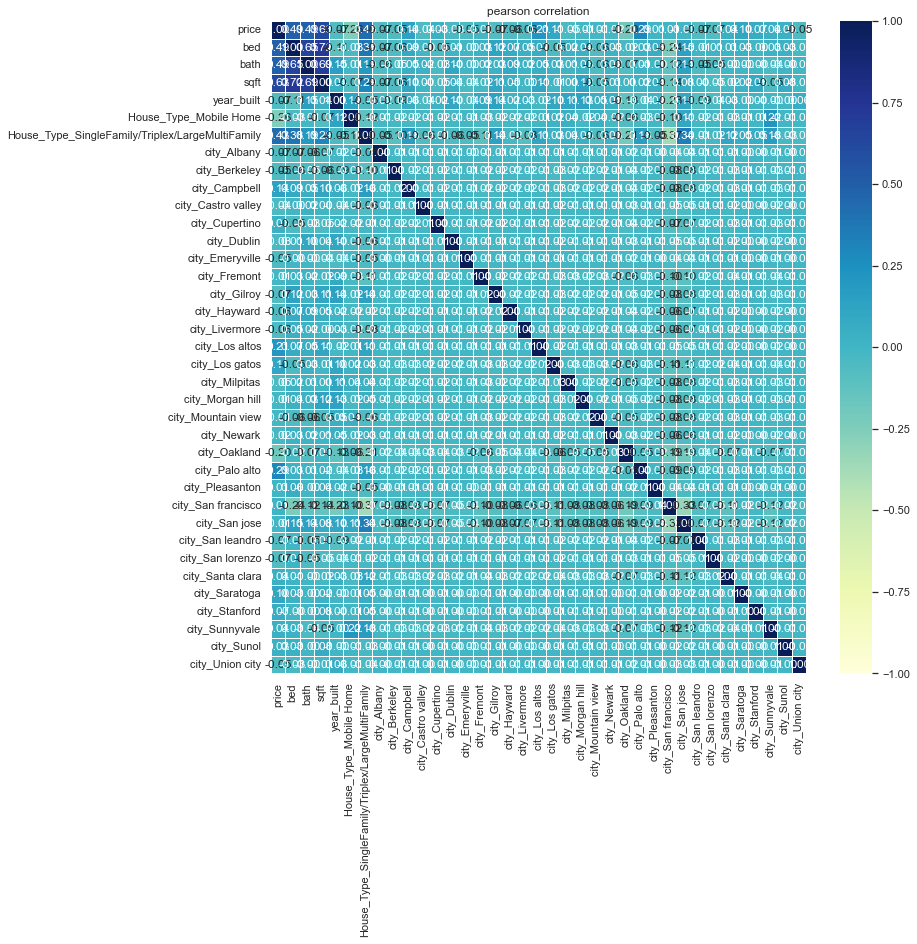

In [43]:
fig, ax = plt.subplots(figsize=(12,12))      
corr_matrix = train_houses.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=1, ax = ax)
plt.title("pearson correlation")

In [44]:
train_houses.columns

Index(['price', 'bed', 'bath', 'sqft', 'year_built', 'House_Type_Mobile Home',
       'House_Type_SingleFamily/Triplex/LargeMultiFamily', 'city_Albany',
       'city_Berkeley', 'city_Campbell', 'city_Castro valley',
       'city_Cupertino', 'city_Dublin', 'city_Emeryville', 'city_Fremont',
       'city_Gilroy', 'city_Hayward', 'city_Livermore', 'city_Los altos',
       'city_Los gatos', 'city_Milpitas', 'city_Morgan hill',
       'city_Mountain view', 'city_Newark', 'city_Oakland', 'city_Palo alto',
       'city_Pleasanton', 'city_San francisco', 'city_San jose',
       'city_San leandro', 'city_San lorenzo', 'city_Santa clara',
       'city_Saratoga', 'city_Stanford', 'city_Sunnyvale', 'city_Sunol',
       'city_Union city'],
      dtype='object')

In [45]:
X_names = ['bath', 'sqft', 'House_Type_Mobile Home',
       'House_Type_SingleFamily/Triplex/LargeMultiFamily', 'city_Albany',
       'city_Berkeley', 'city_Campbell', 
       'city_Cupertino', 'city_Dublin', 'city_Emeryville', 'city_Fremont',
       'city_Gilroy', 'city_Hayward', 'city_Livermore', 'city_Los altos',
       'city_Los gatos', 'city_Milpitas', 'city_Morgan hill',
       'city_Mountain view', 'city_Newark', 'city_Oakland', 'city_Palo alto',
       'city_Pleasanton', 'city_San francisco', 'city_San jose',
       'city_San leandro', 'city_San lorenzo', 'city_Santa clara',
       'city_Saratoga', 'city_Stanford', 'city_Sunnyvale', 
       'city_Union city']

X_train = train_houses_scaled[X_names].values
y_train = train_houses_scaled["price"].values
X_test = valid_houses_scaled[X_names].values
y_test = valid_houses_scaled["price"].values

# Machine Learning Methods

# 1. Multiple Regression

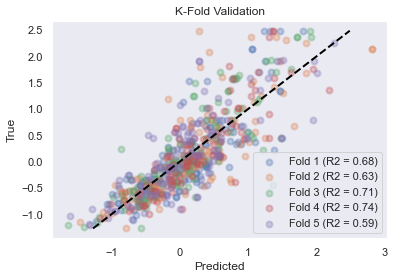

In [46]:
## call model
model = linear_model.LinearRegression()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [47]:
cv.split(X_train, y_train)

<generator object _BaseKFold.split at 0x0000027C83784190>

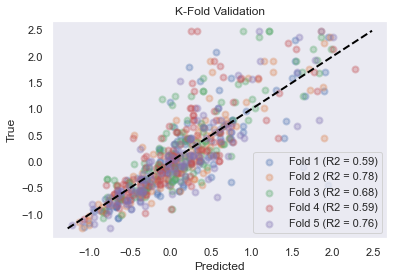

In [48]:
model = ensemble.GradientBoostingRegressor()
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      
             #weighting factor for the corrections by new trees when added to the model
             'n_estimators':[100,250,500,750,1000,1250,1500,1750],  
             #number of trees added to the model
             'max_depth':[2,3,4,5,6,7],                             
             #maximum depth of the tree
             'min_samples_split':[2,4,6,8,10,20,40,60,100],         
             #sets the minimum number of samples to split
             'min_samples_leaf':[1,3,5,7,9],                        
             #the minimum number of samples to form a leaf
             'max_features':[2,3,4,5,6,7],                          
             #square root of features is usually a good starting point
             'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]            
             #the fraction of samples to be used for fitting the individual base learners. Values lower than 1
            }
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

In [49]:
#Using the gradient booster model to predict test data

## train
model.fit(X_train, y_train)
## test
predicted = model.predict(X_test)
#print(predicted)
predicted = scalerY.inverse_transform(predicted.reshape(-1,1) ).reshape(-1)
y_test = scalerY.inverse_transform(y_test.reshape(-1,1) ).reshape(-1)

In [50]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.74
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.19
Mean Absolute Error (Σ|y-pred|/n): 252,646
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 355,386
Max Error: 1,441,467


C:\Users\siraj\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


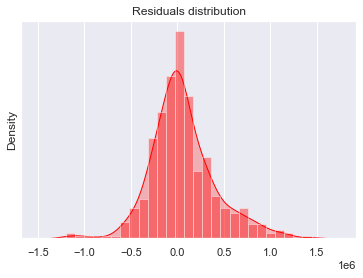

In [51]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()

In [52]:
#Explaining the regression model

In [53]:
predictors = ['bath', 'sqft', 'House_Type', 'city']
outcome = 'price'

#convert to dummy variables and Separate X and y variables
X = pd.get_dummies(houses_df[predictors], drop_first=True)
y = houses_df[outcome]

#Run regression
logit_reg = sm.GLM(y, X, family=sm.families.Binomial())

#Fit and print results
results = logit_reg.fit()
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                 1045
Model:                            GLM   Df Residuals:                     1011
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sun, 05 Mar 2023   Deviance:                   1.4468e+11
Time:                        21:30:26   Pearson chi2:                 1.13e+31
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

C:\Users\siraj\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\siraj\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:947: RuntimeWarning: divide by zero encountered in log
  y * np.log(mu / (1 - mu + 1e-20)) +


In [54]:
print("True:", "{:,.0f}".format(y_test[2]), "--> Pred:", "{:,.0f}".format(predicted[2]))

True: 899,900 --> Pred: 906,539


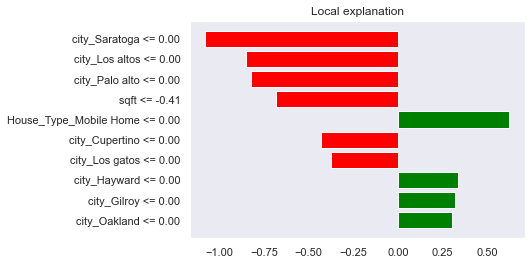

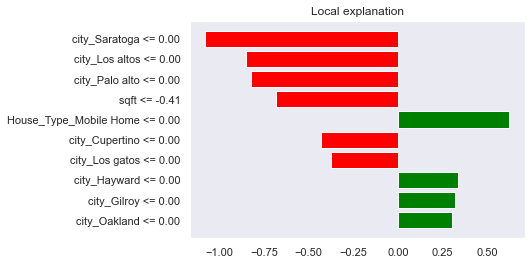

In [55]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names="Y", mode="regression")
explained = explainer.explain_instance(X_test[2], model.predict, num_features=10)
explained.as_pyplot_figure()

In [56]:
#Trying additional multi-reg models with different predictor variables

In [57]:
housing_df = df

In [58]:
predictors = ['city', 'bed', 'bath', 'sqft', 'walkscore', 'transitscore', 'bikescore', 'competitivescore',
       '1st School Rating', 'status', 'House_Type', 'year_built', 'Lotsize']
outcome = 'price'

# partition data
X = pd.get_dummies(housing_df[predictors], drop_first=True)
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

housing_lm = LinearRegression()
housing_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', housing_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': housing_lm.coef_}))

# print performance measures
regressionSummary(valid_y, housing_lm.predict(valid_X))

intercept  84860.33480954007
                                           Predictor   coefficient
0                                                bed  2.547392e+04
1                                               bath  1.093896e+05
2                                               sqft  5.351532e+02
3                                          walkscore -1.090026e+03
4                                       transitscore  1.018136e+03
5                                          bikescore  1.335206e+03
6                                   competitivescore -2.018705e+03
7                                  1st School Rating  5.447993e+04
8                                         year_built -3.307951e+02
9                                            Lotsize  1.197848e+01
10                                       city_Albany  1.808777e+05
11                                     city_Berkeley  3.573092e+05
12                                     city_Campbell  6.500508e+05
13                               

In [59]:
pred_y = housing_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, housing_lm))
print('AIC : ', AIC_score(train_y, pred_y, housing_lm))
print('BIC : ', BIC_score(train_y, pred_y, housing_lm))

adjusted r2 :  0.7101857473280505
AIC :  17960.068684799804
BIC :  18173.234118750184


In [60]:
# Use predict() to make predictions on a new set
housing_lm_pred = housing_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': housing_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - housing_lm_pred})
print('Mean Abolsute Error is ', result.Residual.abs().mean())
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, housing_lm_pred)

Mean Abolsute Error is  285197.1125182379
        Predicted   Actual      Residual
949  1.543557e+06  1350000 -1.935573e+05
94   2.108183e+06  2399000  2.908168e+05
135  8.263236e+05   899900  7.357642e+04
614  1.095364e+06   849950 -2.454136e+05
354  9.747606e+05  1695000  7.202394e+05
404  1.168098e+06   960000 -2.080984e+05
99   8.265194e+05   388888 -4.376314e+05
724  1.233651e+06  1125000 -1.086515e+05
919  2.353651e+06  3398000  1.044349e+06
677  1.267169e+06  1098000 -1.691692e+05
705  2.387022e+06  2999950  6.129283e+05
156  6.882531e+05   757000  6.874689e+04
840  1.470774e+06  1100000 -3.707740e+05
598  1.871670e+06  2715000  8.433303e+05
750  9.794537e+05  2350000  1.370546e+06
943  1.283231e+06   998000 -2.852314e+05
80   4.686269e+05   450000 -1.862685e+04
918  6.751918e+05   549900 -1.252918e+05
758  3.077536e+06  2850000 -2.275361e+05
41   1.659220e+06  1495000 -1.642201e+05

Regression statistics

                      Mean Error (ME) : -49293.8686
       Root Mean Squa

In [61]:
#running forward seleciton model

In [62]:
# The initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

bestFS_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: bed, bath, sqft, walkscore, transitscore, bikescore, competitivescore, 1st School Rating, year_built, Lotsize, city_Albany, city_Berkeley, city_Campbell, city_Castro valley, city_Cupertino, city_Dublin, city_Emeryville, city_Fremont, city_Gilroy, city_Hayward, city_Livermore, city_Los altos, city_Los gatos, city_Milpitas, city_Morgan hill, city_Mountain view, city_Newark, city_Oakland, city_Palo alto, city_Pleasanton, city_San francisco, city_San jose, city_San leandro, city_San lorenzo, city_Santa clara, city_Saratoga, city_Stanford, city_Sunnyvale, city_Sunol, city_Union city, status_Coming Soon, status_New, status_New-REO, status_Price Change, House_Type_Mobile Home, House_Type_SingleFamily/Triplex/LargeMultiFamily
Start: score=18692.47, constant
Step: score=18375.06, add sqft
Step: score=18290.48, add city_Palo alto
Step: score=18231.93, add 1st School Rating
Step: score=18155.96, add House_Type_SingleFamily/Triplex/LargeMultiFamily
Step: score=18097.52, add city_San fra

In [63]:
regressionSummary(valid_y, bestFS_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : -54993.0991
       Root Mean Squared Error (RMSE) : 376854.4499
            Mean Absolute Error (MAE) : 289016.3643
          Mean Percentage Error (MPE) : -8.7134
Mean Absolute Percentage Error (MAPE) : 30.8607


# 2. CART Analysis w/ Binary Price Level

In [64]:
houses_df = df[['Price_Level', 'bath', 'sqft', 'House_Type'] ]

In [65]:
#pip install graphviz

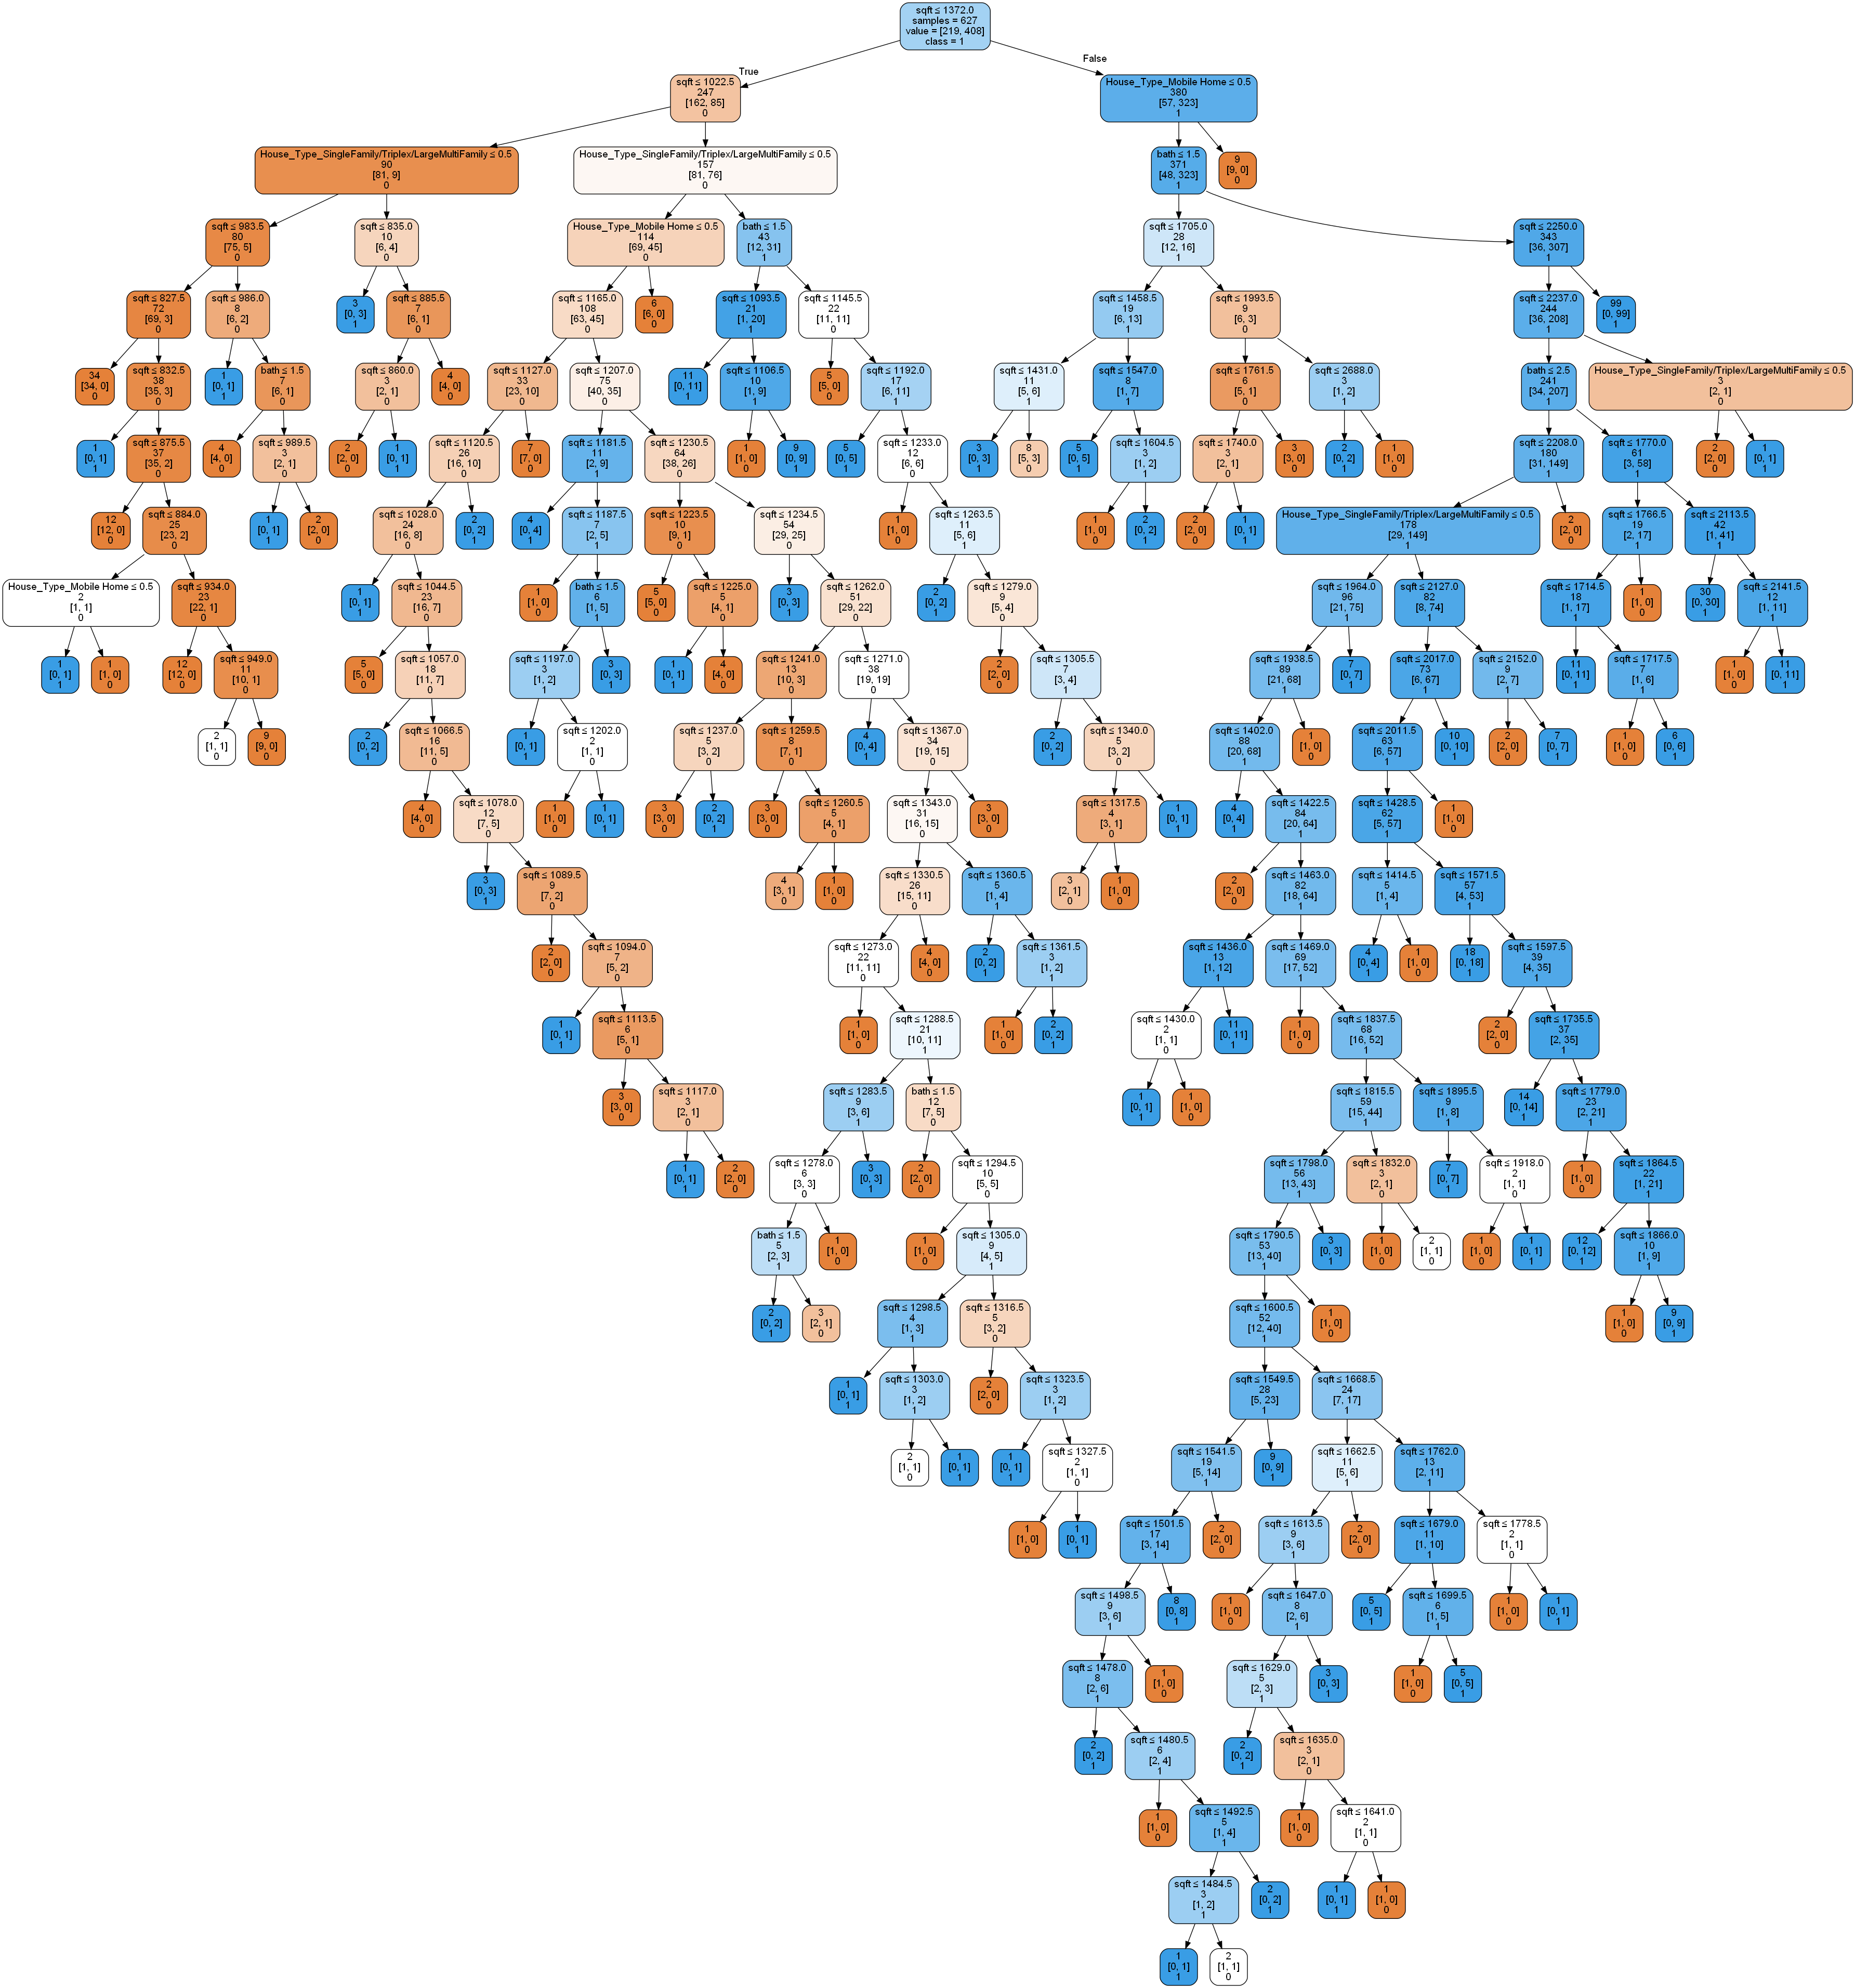

In [66]:
#Running CART for Price Level

#Running CART for price

#Have to first get the dummies
house_df = pd.get_dummies(houses_df, drop_first=True)

#Separate X and y variables
X = house_df.drop(columns=['Price_Level'])
y = house_df['Price_Level']

#Partition
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

#Develop trees
PasteClassTree = DecisionTreeClassifier()
PasteClassTree.fit(train_X, train_y)
plotDecisionTree(PasteClassTree, feature_names=train_X.columns, class_names=PasteClassTree.classes_)

In [67]:
#R squared value for above CART in predicting house being less than or greater than $1M

accuracy_score(valid_y, PasteClassTree.predict(valid_X))

0.8325358851674641

In [68]:
#Boosted Tree

boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

GradientBoostingClassifier()

In [69]:
#classificationSummary(valid_y, boost.predict(valid_X))
accuracy_score(valid_y, boost.predict(valid_X))

0.8229665071770335

# CART Analysis w/ Pricing Groups

In [70]:
housing_df = df

housing_df['Price_Level_New'] = [
    1 if index <= 250000 else
    2 if index <= 500000 else
    3 if index <= 1000000 else
    4 if index <= 1500000 else
    5 for index in housing_df['price']]

In [71]:
housing_df.columns

Index(['street', 'city', 'state', 'zipcode', 'price', 'bed', 'bath', 'sqft',
       'walkscore', 'transitscore', 'bikescore', 'competitivescore',
       '1st School Rating', 'status', 'house_type', 'year_built', 'Lotsize',
       'perSq_Ft', 'Price_Level', 'House_Type', 'county', 'price_bucket',
       'Price_Level_New'],
      dtype='object')

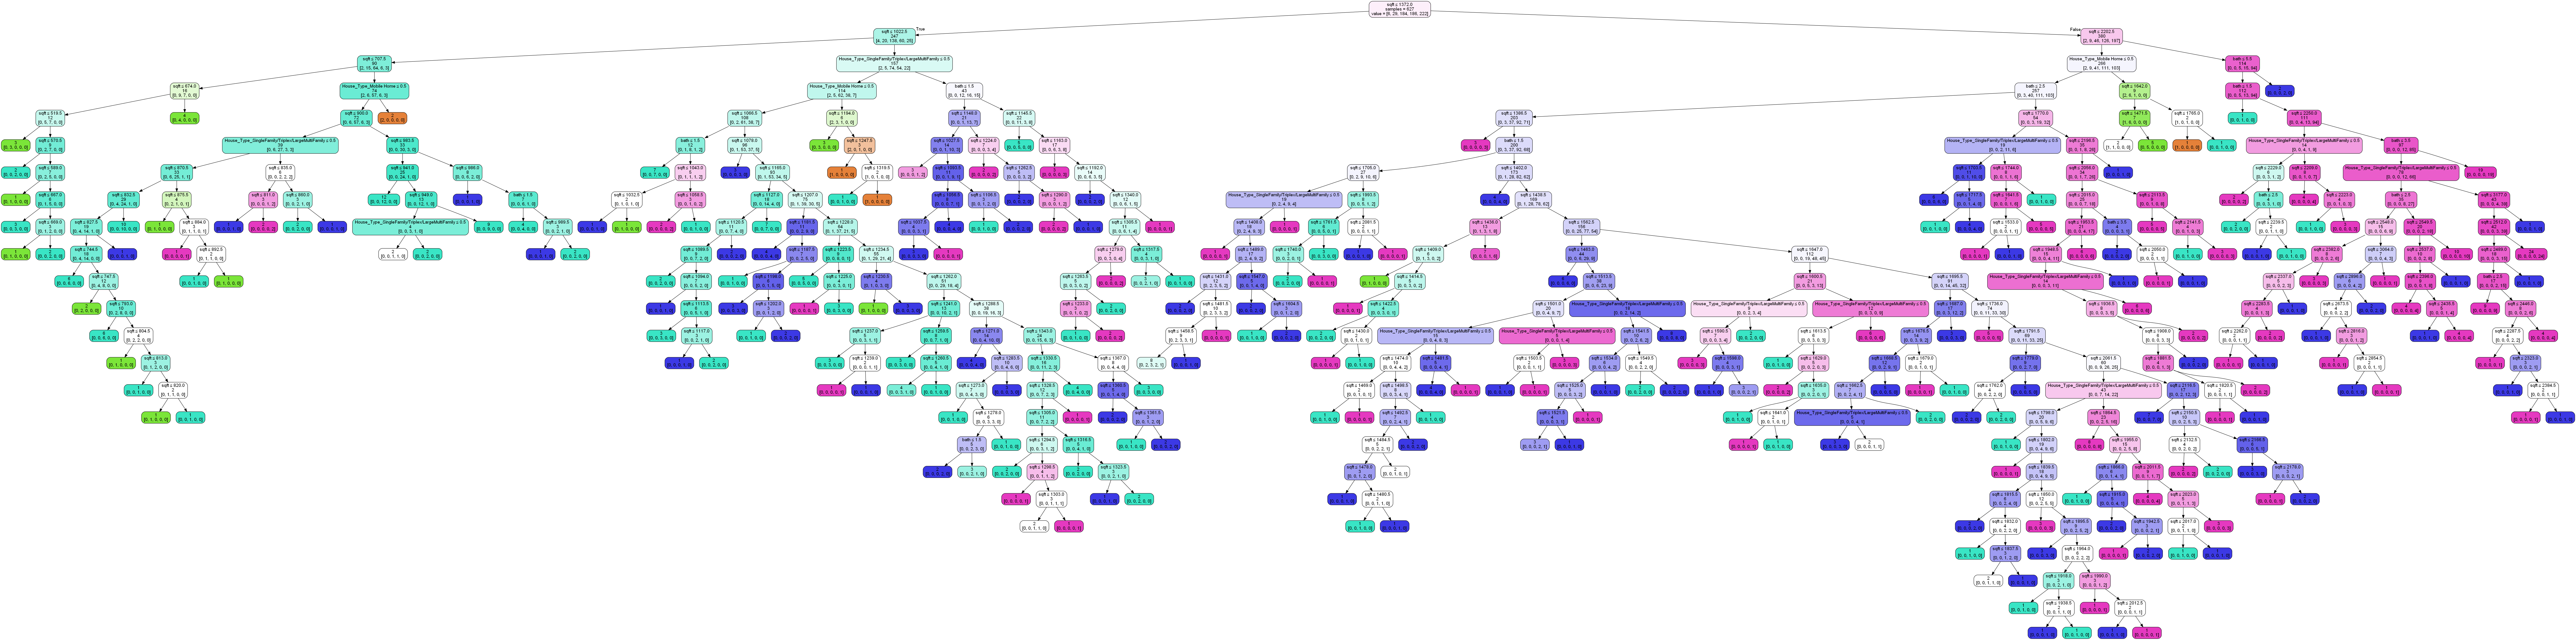

In [72]:
housing_df = housing_df[[ 'bath', 'sqft', 'House_Type', 'Price_Level_New']]

#Have to first get the dummies
housing_df = pd.get_dummies(housing_df, drop_first=True)

#Separate X and y variables
X = housing_df.drop(columns=['Price_Level_New'])
y = housing_df['Price_Level_New']

#Partition
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

#Develop trees
NewClassTree = DecisionTreeClassifier()
NewClassTree.fit(train_X, train_y)

plotDecisionTree(NewClassTree, feature_names=train_X.columns)

In [73]:
classificationSummary(housing_df['Price_Level_New'], NewClassTree.predict(housing_df.drop(columns=['Price_Level_New'])))

Confusion Matrix (Accuracy 0.8459)

       Prediction
Actual   0   1   2   3   4
     0  12   0   1   0   0
     1   6  36   8   0   2
     2   0   7 285  23  13
     3   0   0  32 240  42
     4   0   1   9  17 311


In [74]:
#Calculate accuracy for validation data
accuracy_score(valid_y, NewClassTree.predict(valid_X))

0.6578947368421053

In [75]:
#Boosted Tree

boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

GradientBoostingClassifier()

In [76]:
#classificationSummary(valid_y, boost.predict(valid_X))
accuracy_score(valid_y, boost.predict(valid_X))

0.6196172248803827

In [77]:
#trying variations to get a better score

In [78]:
housing_df = df

housing_df['Price_Level_New'] = [
    1 if index <= 250000 else
    2 if index <= 500000 else
    3 if index <= 1000000 else
    4 if index <= 1500000 else
    5 for index in housing_df['price']]

In [79]:
housing_df = housing_df[[ 'bath', 'sqft', 'city', 'House_Type', 'Price_Level_New']]

#Have to first get the dummies
housing_df = pd.get_dummies(housing_df, drop_first=True)

#Separate X and y variables
X = housing_df.drop(columns=['Price_Level_New'])
y = housing_df['Price_Level_New']

#Partition
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

#Develop trees
NewClassTree = DecisionTreeClassifier()
NewClassTree.fit(train_X, train_y)

#plotDecisionTree(NewClassTree, feature_names=train_X.columns)

DecisionTreeClassifier()

In [80]:
classificationSummary(housing_df['Price_Level_New'], NewClassTree.predict(housing_df.drop(columns=['Price_Level_New'])))

Confusion Matrix (Accuracy 0.8689)

       Prediction
Actual   0   1   2   3   4
     0  12   1   0   0   0
     1   2  40   9   0   1
     2   0   6 289  23  10
     3   0   0  34 250  30
     4   0   1   3  17 317


In [81]:
#Calculate accuracy for validation data
accuracy_score(valid_y, NewClassTree.predict(valid_X))

0.7009569377990431

In [82]:
#Boosted Tree

boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

GradientBoostingClassifier()

In [83]:
#classificationSummary(valid_y, boost.predict(valid_X))
accuracy_score(valid_y, boost.predict(valid_X))

0.6794258373205742

# 3. kNN

In [84]:
#Start with continuous price model:
X_names = ['bath', 'sqft', 'House_Type_Mobile Home',
       'House_Type_SingleFamily/Triplex/LargeMultiFamily', 'city_Albany',
       'city_Berkeley', 'city_Campbell', 
       'city_Cupertino', 'city_Dublin', 'city_Emeryville', 'city_Fremont',
       'city_Gilroy', 'city_Hayward', 'city_Livermore', 'city_Los altos',
       'city_Los gatos', 'city_Milpitas', 'city_Morgan hill',
       'city_Mountain view', 'city_Newark', 'city_Oakland', 'city_Palo alto',
       'city_Pleasanton', 'city_San francisco', 'city_San jose',
       'city_San leandro', 'city_San lorenzo', 'city_Santa clara',
       'city_Saratoga', 'city_Stanford', 'city_Sunnyvale', 
       'city_Union city']

X_train = train_houses_scaled[X_names].values
y_train = train_houses_scaled["price"].values
X_test = valid_houses_scaled[X_names].values
y_test = valid_houses_scaled["price"].values

In [85]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)


In [86]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [87]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

0.32768971834177363

In [88]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

0.4899092890860622

In [89]:
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [90]:
gridsearch.best_params_

{'n_neighbors': 9}

In [91]:
train_preds_grid = gridsearch.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
train_rmse

test_rmse

0.512851603601569

In [92]:
#Compare the fit of the model with 8 nearest neighbors on training data to 3 NN
knn_model8 = KNeighborsRegressor(n_neighbors=8)
knn_model8.fit(X_train, y_train)
train_preds8 = knn_model8.predict(X_train)
mse = mean_squared_error(y_train, train_preds8)
rmse = sqrt(mse)
rmse

0.4178482948516704

In [93]:
#Confirm above result for the validation data
test_preds8 = knn_model8.predict(X_test)
mse = mean_squared_error(y_test, test_preds8)
rmse = sqrt(mse)
rmse
#Conclusion: 8 nearest neighbors produces a better result on the training dataset than 3 nearest neighbors
#but performance is worse on the validation dataset

0.5168860035175222

In [94]:
#try with categorical price bucket variable and with a different scaler
#Not using some of the other variables because can see right off the back that it doesnt have direct correlation with price, but can be useful for clustering
houses_df = df[['price_bucket', 'bed', 'bath', 'sqft', 'House_Type', 'year_built', 'city'] ]
train_houses, valid_houses = train_test_split(houses_df, test_size=0.4, random_state=1)
scaler = preprocessing.StandardScaler()
scaler.fit(train_houses[['sqft', 'year_built', 'bed', 'bath']]) 


StandardScaler()

 Repeat process for categorical price variable

In [95]:
#Transform the full dataset
house_norm = pd.concat([pd.DataFrame(scaler.transform(houses_df[['sqft', 'year_built', 'bed', 'bath']]), 
                                      columns=['zSQFT', 'zYEAR_BUILT', 'zBED', 'zBATH']), 
                        houses_df[['price_bucket', 'House_Type', 'city']]], axis=1)

house_norm = pd.get_dummies(house_norm, drop_first=True)
house_norm['price_bucket'] = house_norm['price_bucket'].astype('category')

trainNorm = house_norm.iloc[train_houses.index]
validNorm = house_norm.iloc[valid_houses.index]

trainNorm.columns

Index(['zSQFT', 'zYEAR_BUILT', 'zBED', 'zBATH', 'price_bucket',
       'House_Type_Mobile Home',
       'House_Type_SingleFamily/Triplex/LargeMultiFamily', 'city_Albany',
       'city_Berkeley', 'city_Campbell', 'city_Castro valley',
       'city_Cupertino', 'city_Dublin', 'city_Emeryville', 'city_Fremont',
       'city_Gilroy', 'city_Hayward', 'city_Livermore', 'city_Los altos',
       'city_Los gatos', 'city_Milpitas', 'city_Morgan hill',
       'city_Mountain view', 'city_Newark', 'city_Oakland', 'city_Palo alto',
       'city_Pleasanton', 'city_San francisco', 'city_San jose',
       'city_San leandro', 'city_San lorenzo', 'city_Santa clara',
       'city_Saratoga', 'city_Stanford', 'city_Sunnyvale', 'city_Sunol',
       'city_Union city'],
      dtype='object')

In [96]:
#trainNorm.columns.drop(columns='price_bucket')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [97]:
train_X = trainNorm.drop(columns=['price_bucket'])
train_y = trainNorm['price_bucket']
valid_X = validNorm.drop(columns=['price_bucket'])
valid_y = validNorm['price_bucket']

#Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k':k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

#Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.578947
1    2  0.533493
2    3  0.488038
3    4  0.485646
4    5  0.502392
5    6  0.509569
6    7  0.502392
7    8  0.504785
8    9  0.511962
9   10  0.511962
10  11  0.507177
11  12  0.516746
12  13  0.502392
13  14  0.507177


In [98]:
#from above - best k =1
knn = KNeighborsClassifier(n_neighbors=1).fit(trainNorm.drop(columns=['price_bucket']), trainNorm['price_bucket'])
#accuracy_score(validNorm['price_bucket'], knn.predict(validNorm.drop(columns=['price_bucket'])))
classificationSummary(validNorm['price_bucket'], knn.predict(validNorm.drop(columns=['price_bucket'])))

Confusion Matrix (Accuracy 0.5789)

       Prediction
Actual  0  1  2  3  4
     0 69 18  3  2  1
     1 16 36 30  9  1
     2  5 10 40 23 11
     3  2  0 15 32 14
     4  0  0  6 10 65


# 4 Logistic Regression

In [99]:
#Fit logistic Model
logit_full =LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

print('intercept', logit_full.intercept_[0])
print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=train_X.columns).transpose())

print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df = len(train_X.columns) + 1))

intercept -6.431316309152559
          zSQFT  zYEAR_BUILT     zBED     zBATH  House_Type_Mobile Home  \
coeff -3.226426     0.071906 -0.48088  0.344737               18.217774   

       House_Type_SingleFamily/Triplex/LargeMultiFamily  city_Albany  \
coeff                                         -3.042326     3.619037   

       city_Berkeley  city_Campbell  city_Castro valley  city_Cupertino  \
coeff       0.935837       4.226227           -5.864802       -6.811834   

       city_Dublin  city_Emeryville  city_Fremont  city_Gilroy  city_Hayward  \
coeff     -4.97703         2.700597      3.242575     7.696592     -5.113248   

       city_Livermore  city_Los altos  city_Los gatos  city_Milpitas  \
coeff        3.503967       -0.001908         2.96611       2.630427   

       city_Morgan hill  city_Mountain view  city_Newark  city_Oakland  \
coeff         -3.475936            4.176835     4.850274      5.351323   

       city_Palo alto  city_Pleasanton  city_San francisco  city_San 

In [100]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y,
                           'p(0)': [p[0] for p in logit_reg_pred],
                           'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

#confusion matrix
classes=['<=$60000', '<=$798978', '<=$1096800', '<=$1395000', '<=$3500000']
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

Confusion Matrix (Accuracy 0.5167)

           Prediction
    Actual   <=$60000  <=$798978 <=$1096800 <=$1395000 <=$3500000
  <=$60000         72         17          3          0          1
 <=$798978         25         33         18         15          1
<=$1096800          4         22         21         32         10
<=$1395000          1          4         11         35         12
<=$3500000          0          4          4         18         55


# 5. Clustering

In [101]:
df_num_vars = df.select_dtypes(include='number').drop(columns=['price_bucket', 'Price_Level', 'perSq_Ft', 'Lotsize'])
df_num_vars.head() #dropping redundant variables

price  bed  bath  sqft  walkscore  transitscore  bikescore  \
0   649000    2     2  1037         96            86         91   
1   699000    2     2   990         82            51         47   
2   685000    1     1  1010         94            59         86   
3  1000000    2     2  1492         76            41         56   
4   749000    4     2  1836         91            57         68   

   competitivescore  1st School Rating  year_built  Price_Level_New  
0                76                  2        2003                3  
1                71                  3        1930                3  
2                69                  4        2006                3  
3                77                  7        2007                3  
4                73                  2        1941                3

In [102]:
clust_df_norm = (df_num_vars - df_num_vars.mean()) / df_num_vars.std()
clust_df_norm.head()

price       bed      bath      sqft  walkscore  transitscore  bikescore  \
0 -1.019338 -0.944481 -0.008742 -0.956563   1.214358      1.567262   1.211741   
1 -0.949197 -0.944481 -0.008742 -1.032854   0.698338      0.224278  -0.748221   
2 -0.968836 -1.852468 -1.313821 -1.000389   1.140641      0.531245   0.989018   
3 -0.526942 -0.944481 -0.008742 -0.218000   0.477187     -0.159432  -0.347320   
4 -0.879055  0.871494 -0.008742  0.340386   1.030065      0.454503   0.187215   

   competitivescore  1st School Rating  year_built  Price_Level_New  
0          0.464710          -1.914101    1.041541         -0.90351  
1          0.236633          -1.437173   -1.069687         -0.90351  
2          0.145402          -0.960245    1.128304         -0.90351  
3          0.510326           0.470538    1.157225         -0.90351  
4          0.327864          -1.914101   -0.751557         -0.90351

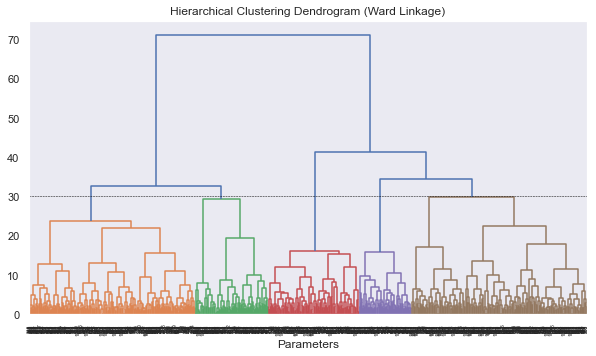

In [103]:
Z = linkage(clust_df_norm, method='ward', metric = 'euclidean') 
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Parameters')
# 'color_threshold = 25' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (25), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z, labels=clust_df_norm.index, color_threshold=30)
plt.axhline(y=30, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

#dendrogram not very useful, given that there are too many parameters

In [104]:
memb = fcluster(Z, 4, criterion='maxclust') #no more than 4 clusters
#print(memb)

#The above variable has membership of each row. To make it presentable we reorganize next
#memb = pd.Series(memb, index=house_norm.index)
#for key, item in memb.groupby(memb):
#    print(key, ': ', ', '.join(item.index))

In [105]:
#Create Means of each Cluster or Create data frame with means of each input variable (measurement) for each cluster 
clust_mean = df_num_vars.groupby(memb).mean() #the reason the original dataset is used, because for the output we are not 
#intersted in normalized means - they are hard to interpret, we wish to interpret the cluster means in the actual data

# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals. 
clust_mean['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean.index]
pd.set_option('display.precision', 3)

# Display the data frame with mean values and cluster titles.
print('Means of Input Variables for Clusters with Ward Linkage Method')
print(clust_mean)

Means of Input Variables for Clusters with Ward Linkage Method
       price    bed   bath      sqft  walkscore  transitscore  bikescore  \
1  9.055e+05  2.285  1.552  1182.659     77.470        60.339     71.610   
2  1.160e+06  3.253  2.000  1680.094     29.953        21.076     37.641   
3  1.883e+06  3.907  2.577  2182.814     88.515        67.515     76.330   
4  1.979e+06  3.705  2.462  2039.884     52.976        30.283     62.954   

   competitivescore  1st School Rating  year_built  Price_Level_New    Cluster  
1            57.742              5.510    1966.076            3.185  Cluster 1  
2            69.682              5.429    1974.253            3.729  Cluster 2  
3            60.289              6.577    1918.062            4.711  Cluster 3  
4            76.456              6.836    1978.900            4.638  Cluster 4  


In [106]:
for cluster, data in df_num_vars.groupby(memb):
    count = len(data)
    print(f'Cluster {cluster} ({count} members)')

Cluster 1 (449 members)
Cluster 2 (170 members)
Cluster 3 (97 members)
Cluster 4 (329 members)


Means of Normalized Input Variables for Clusters with Ward Linkage Method
   price    bed   bath   sqft  walkscore  transitscore  bikescore  \
1 -0.660 -0.686 -0.593 -0.720      0.531         0.583      0.348   
2 -0.302  0.193 -0.009  0.087     -1.220        -0.924     -1.165   
3  0.712  0.787  0.745  0.903      0.938         0.858      0.558   
4  0.847  0.604  0.594  0.671     -0.371        -0.571     -0.038   

   competitivescore  1st School Rating  year_built  Price_Level_New    Cluster  
1            -0.368             -0.240      -0.026           -0.712  Cluster 1  
2             0.177             -0.279       0.210           -0.148  Cluster 2  
3            -0.252              0.269      -1.415            0.868  Cluster 3  
4             0.486              0.392       0.345            0.793  Cluster 4  


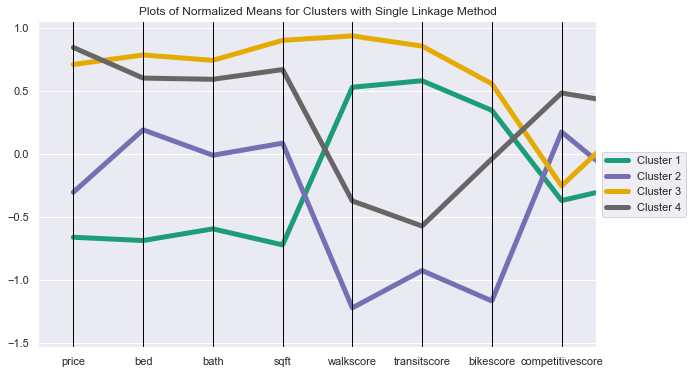

In [107]:
#for the plots you want normalized data, so redo the calculations above with normalized data
clust_mean_norm = clust_df_norm.groupby(memb).mean()

# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals. 

clust_mean_norm['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean_norm.index]
pd.set_option('display.precision', 3)

# Display the data frame with normalized mean values and cluster titles.
print('Means of Normalized Input Variables for Clusters with Ward Linkage Method')
print(clust_mean_norm)

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(clust_mean_norm, class_column='Cluster', 
                          colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-0.5,7.5)
plt.title('Plots of Normalized Means for Clusters with Single Linkage Method')
plt.show()